# <font color=darkblue>Deep learning for Non Intrusive Load Monitoring (NILM) - Part III</font>



## <font color=darkred> Bibliography & additional ressources </font>

- [1] https://github.com/nilmtk/nilmtk
``NILMTK is a toolkit designed to help researchers evaluate the accuracy of NILM algorithms``.
- [2] https://arxiv.org/pdf/2306.05017 `A nice review of deep learning for NILM``
- [3] https://github.com/ETSSmartRes/VAE-NILM
``Energy disaggregation using variational autoencoders``
- [4] https://github.com/Ming-er/NeuralNILM_Pytorch
``Several deep learning implementation for NILM including BiLSTM and CNN with attention``
- [5] https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10099094/ ``New framework based on conditional diffusion models with nice bibliography``
- [6] https://github.com/k-nut/nilm-datasets/blob/master/nilm-datasets.csv ``Several NILM datasets``
- [7] https://arxiv.org/pdf/1904.05948 ``An algorithm to use VAE to perform regression``. This paper and the associated notebook https://colab.research.google.com/github/curiousily/Getting-Things-Done-with-Pytorch/blob/master/06.time-series-anomaly-detection-ecg.ipynb#scrollTo=WT4BekX2g4L_ for anomaly detection were used for the regression part of this notebook.

## <font color=darkred> Non intrusive load monitoring</font>


**Nonintrusive load monitoring (NILM)** or energy disaggregation is a process for analyzing detailed consumptions and deducing what **appliances are used** based on **aggregated data**.

Automated NILM provides valuable insights into energy usage behavior, and **fosters energy conservation, and optimize load management**.

![](https://www.researchgate.net/profile/Dea-Pujic/publication/342962857/figure/fig1/AS:929109328793602@1598528334547/Non-Intrusive-Load-Monitoring-concept.png)

NILM based on standard statistical approaches use mainly **Hidden Markov Model (HMM)**.

Deep learning-based solutions have brought new methodologies adopted from  Computer Vision, Natural Language Processing, Signal Processing: **attention mechanism, variational inference, recurrent neural networks**.

NILM is a severly **ill-posed inverse problem**. For instance, for the UK-dale dataset https://paperswithcode.com/dataset/uk-dale :

![](https://production-media.paperswithcode.com/datasets/Screenshot_2021-04-23_at_12.11.17.png)

**UK-DALE**: open-access dataset from the UK recording Domestic Appliance-Level Electricity. Provide the **aggregate demand per building** but also the **demand of individual appliances**.

Contains five houses, one of which was recorded for 655 days (at 16 kHz for the aggregate demand and at 1/6 Hz for individual appliances).

*Example outputs produced by neural network architectures for three appliances*
![](https://d3i71xaburhd42.cloudfront.net/7e629447855f235857cc2ae8d155a215f03fbf87/8-Figure2-1.png)

**Top row**: measured aggregate power data from House 1 (the input to the neural nets).

**Second row**: single-appliance power demand (i.e. the output to be predicted by the neural nets).

**Middle group of rows**: raw output from each neural network.

**Bottom group of rows**:  result of sliding the network over the aggregate data with STRIDE=16 and overlapping the output.

**Many solutions exist for highly instrumented houses and small buildings but there are no satisfactory solutions (nor datasets) for big buildings with few data**.

The problem still may be solved with additional exertnal information (weather, information on the building, transfer learning).

Using generative models to solve this problem requires:
- (i) Understanding <font color=darkblue> **training from scratch to understand each building block**</font> ;
- (ii.a) Understanding <font color=darkblue>**specific implementation for time series**</font> ;
- (ii.b) Understanding <font color=darkblue>**implementation with conditioning information**</font>.
- (iii) understanding how to use additional specific data (weather, occupation profile).


<font color=darkblue>**Data in the context of NILM**</font>
- Input time series $U$ containing weather information, scheduling, aggregated demand).
- Output time series $X$ to be predicted (individual appliances).


In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
np.set_printoptions(precision=2)
plt.rcParams.update(
    {
        "font.size": 25,
        "figure.figsize": (14, 7),
        "axes.grid": True,
        "grid.color": "#93a1a1",
        "grid.alpha": 0.3,
        "axes.spines.top": False,
        "axes.spines.right": False,
    }
)

## <font color=darkred> Load data (APS - on hold)</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_samples = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NILM/aps_detailed_results_2024-06-06_10-36-27.xlsx')
df_samples.head()

N jour de l'annee  Jour semaine Chauffage programmation CTA Climatisation  \
0                1.0           7.0     False             False         False   
1                1.0           7.0     False             False         False   
2                1.0           7.0     False             False         False   
3                1.0           7.0     False             False         False   
4                1.0           7.0     False             False         False   

   Heure lEgale  Heure solaire              Date  Temperature de l'air  \
0           1.0            0.0  01/01/2023 01:00                  15.2   
1           2.0            1.0  01/01/2023 02:00                  15.1   
2           3.0            2.0  01/01/2023 03:00                  14.7   
3           4.0            3.0  01/01/2023 04:00                  14.7   
4           5.0            4.0  01/01/2023 05:00                  14.6   

   Humidite relative de l'air exterieur  ...  \
0                                  48.0  ...   
1                                  50.0  ...   
2                                  54.0  ...   
3                                  57.0  ...   
4                                  58.0  ...   

   Système de refroidissement  variante 1   EERy1  EERy2.1  \
0                                     0.0  0.5607      0.0   
1                                     0.0  0.5607      0.0   
2                                     0.0  0.5607      0.0   
3                                     0.0  0.5607      0.0   
4                                     0.0  0.5607      0.0   

   Système de refroidissement  variante 2  EERy1.1  EERy2.2  \
0                                     0.0   0.5607      0.0   
1                                     0.0   0.5607      0.0   
2                                     0.0   0.5607      0.0   
3                                     0.0   0.5607      0.0   
4                                     0.0   0.5607      0.0   

   Système de refroidissement  variante 3  EERy1.2  EERy2.3  \
0                                     0.0   0.5607      0.0   
1                                     0.0   0.5607      0.0   
2                                     0.0   0.5607      0.0   
3                                     0.0   0.5607      0.0   
4                                     0.0   0.5607      0.0   

   Système de refroidissement  variante 4  
0                                     0.0  
1                                     0.0  
2                                     0.0  
3                                     0.0  
4                                     0.0  

[5 rows x 140 columns]

In [ ]:
Aggregated_co = df_samples['sommation de la consommation en confort en réduit et en accéléré']
Aggregated_co.head()

0     8.477249
1     8.750514
2    10.081805
3     9.913115
4    10.248543
Name: sommation de la consommation en confort en réduit et en accéléré, dtype: float64

In [ ]:
X = df_samples.drop(df_samples.iloc[:,43::],axis=1)
X = X.drop(X.iloc[:,0:8],axis=1)
X['aggregated_co'] = Aggregated_co
X = X[X.columns.drop(list(X.filter(regex='rayonnement')))]
X = X[X.columns.drop(list(X.filter(regex='solaire')))]
X = X[X.columns.drop(list(X.filter(regex='soleil')))]
X.shape

(8735, 25)

In [ ]:
X.head()

Temperature de l'air  Humidite relative de l'air exterieur  \
0                  15.2                                  48.0   
1                  15.1                                  50.0   
2                  14.7                                  54.0   
3                  14.7                                  57.0   
4                  14.6                                  58.0   

   Pression de vapeur saturante de l'air extérieur  \
0                                      1733.899764   
1                                      1722.778375   
2                                      1678.917290   
3                                      1678.917290   
4                                      1668.106634   

   Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
0                                         832.271887                         
1                                         861.389188                         
2                                         906.615337                         
3                                         956.982855                         
4                                         967.501848                         

   humidité absolue de l'air extérieur kge/kggas (re)  \
0                                           0.005176    
1                                           0.005359    
2                                           0.005643    
3                                           0.005959    
4                                           0.006025    

   enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
0                           28.380426                             0.827139   
1                           28.740721                             0.827093   
2                           29.052076                             0.826319   
3                           29.852106                             0.826735   
4                           29.917587                             0.826535   

   température intérieure en été et en hiver sans ralenti selon calendier clim    tih et tié  \
0                                               22.0                                           
1                                               22.0                                           
2                                               22.0                                           
3                                               22.0                                           
4                                               22.0                                           

      S  pression de vapeur saturante été et hiver sans ralenti  ...  \
0  55.0                                        2655.099984       ...   
1  55.0                                        2655.099984       ...   
2  55.0                                        2655.099984       ...   
3  55.0                                        2655.099984       ...   
4  55.0                                        2655.099984       ...   

   Humidité absolue de l'air intérieure été et hiver avec ralenti( ri)  \
0                                           0.007109                     
1                                           0.007109                     
2                                           0.007109                     
3                                           0.007109                     
4                                           0.007109                     

   enthalpie de l'air intérieur en hiver et en été et en confort et en ralenti  \
0                                          36.122623                             
1                                          36.122623                             
2                                          36.122623                             
3                                          36.122623                             
4                                          36.122623                             

   Declinaion  Heure (rd)  Orientation  angle incident ori

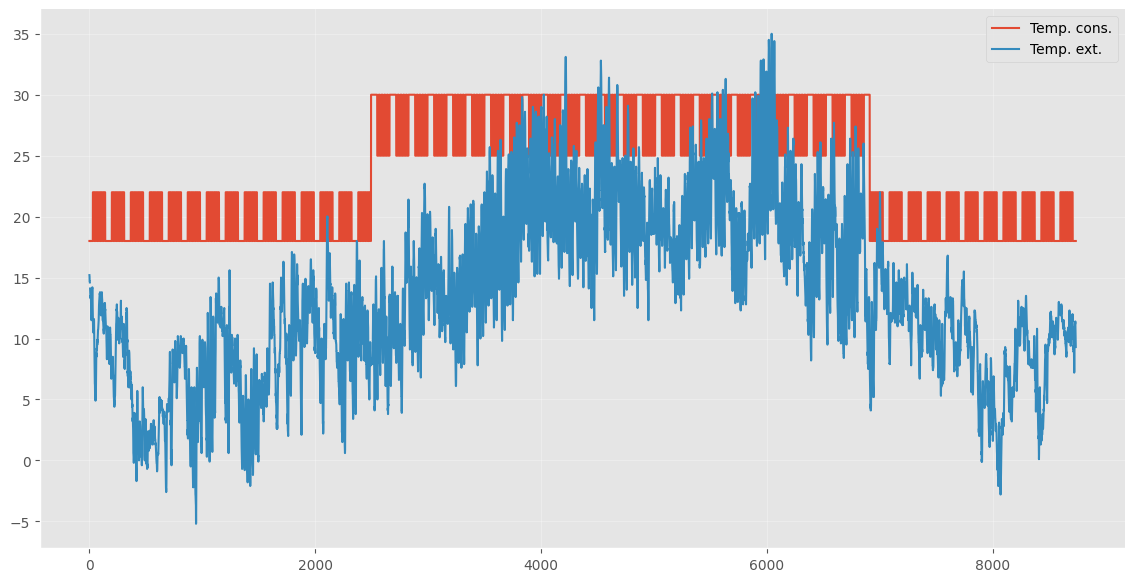

In [ ]:
plt.plot(X['Température intérieure été et hiver par défaut ou relevée avec ralenti (tih,trih) (tié et trié)'],label = 'Temp. cons.')
plt.plot(X["Temperature de l'air"],label = 'Temp. ext.')
plt.legend()

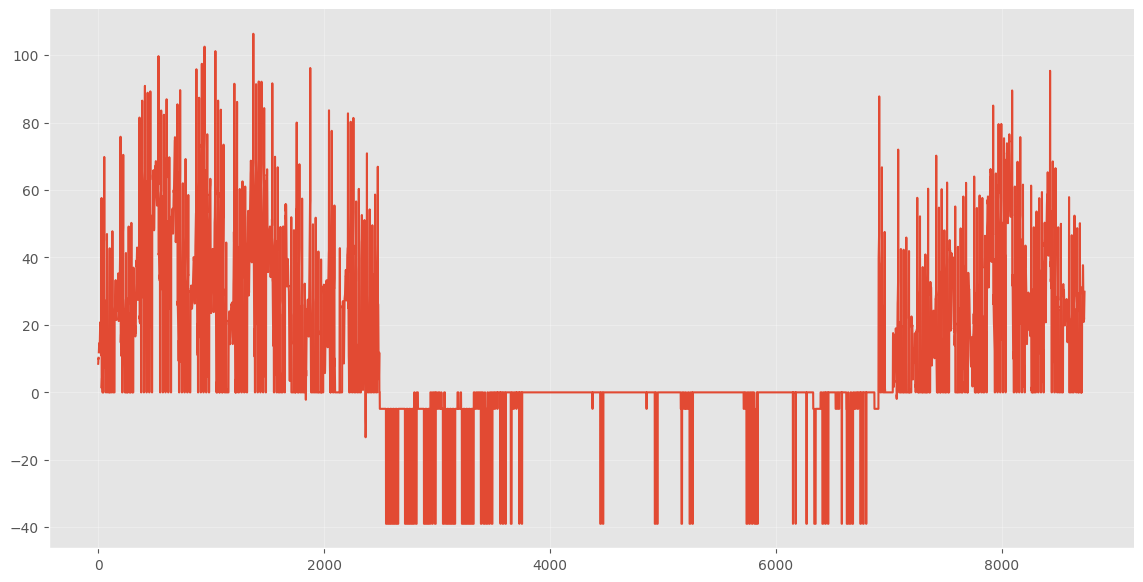

In [ ]:
plt.plot(Aggregated_co)

In [ ]:
Y = df_samples.filter(items=['consommation d\'énergie batterie froide en été CTA permanente suppression valeur positives','consommation d\'énergie de la batterie froide en été CTA en occupation valeurs positives seulement','Besoins de froid variante 1 (permanent)été (ventilation +statique+infiltration +VMC)','besoins de froid variante 2 (ventilation discontinue)  été','variante 3 climatisation arrêtée en innocupation (valeur température trié très grande)','consommation en réduit suppression de la cons si tint>tirh'])
Y.shape

(8735, 6)

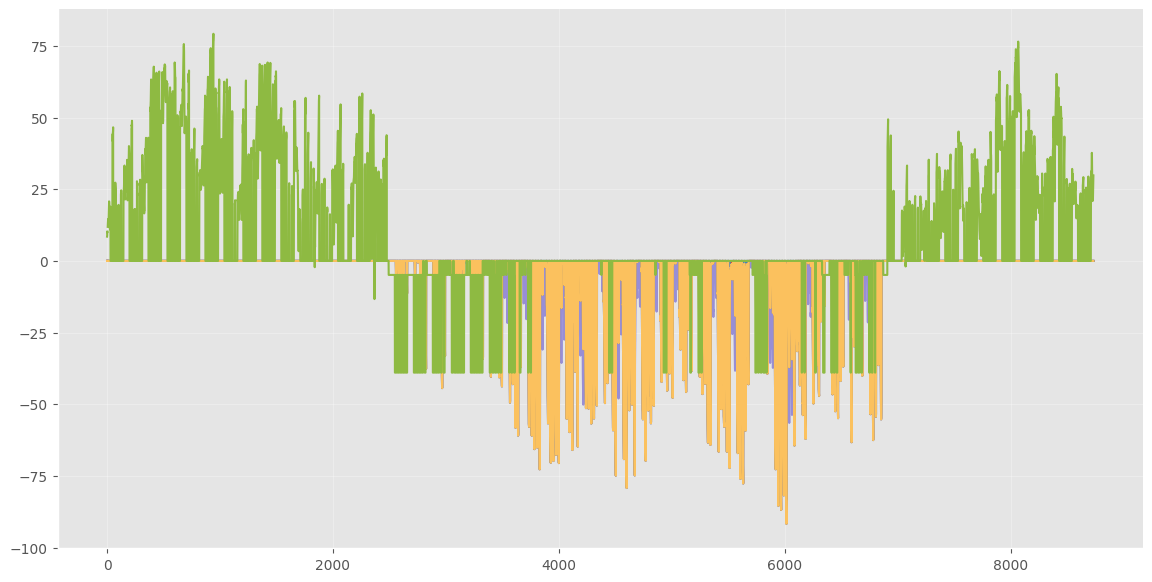

In [ ]:
plt.plot(Y);

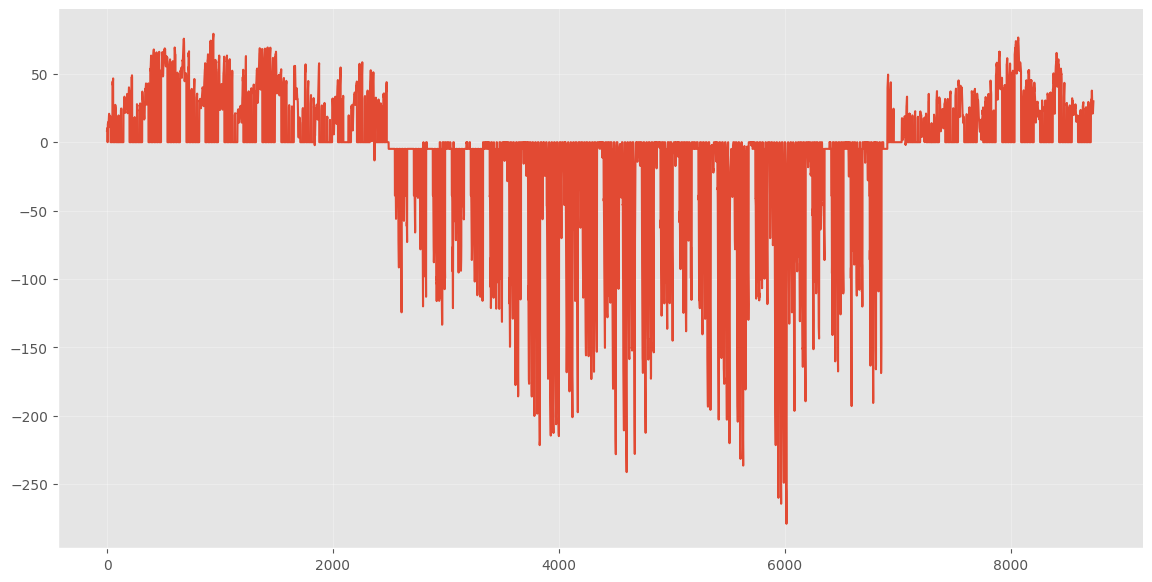

In [ ]:
X['aggregated_co'] = Y.sum(axis=1)
plt.plot(X['aggregated_co'])

In [ ]:
X['batterie_froide_été_CTA_permanente_supp'] = Y['consommation d\'énergie batterie froide en été CTA permanente suppression valeur positives']

In [ ]:
X['batterie_froide_été_CTA_occupation_pos'] = Y['consommation d\'énergie de la batterie froide en été CTA en occupation valeurs positives seulement']

In [ ]:
X['besoin_froid_v1'] = Y['Besoins de froid variante 1 (permanent)été (ventilation +statique+infiltration +VMC)']

In [ ]:
X['besoin_froid_v2'] = Y['besoins de froid variante 2 (ventilation discontinue)  été']

In [ ]:
X['besoin_v3'] = Y['variante 3 climatisation arrêtée en innocupation (valeur température trié très grande)']

In [ ]:
X['co_reduit_sup'] = Y['consommation en réduit suppression de la cons si tint>tirh']

In [ ]:
X.shape

(8735, 25)

In [ ]:
X.head()

Temperature de l'air  Humidite relative de l'air exterieur  \
0                  15.2                                  48.0   
1                  15.1                                  50.0   
2                  14.7                                  54.0   
3                  14.7                                  57.0   
4                  14.6                                  58.0   

   Pression de vapeur saturante de l'air extérieur  \
0                                      1733.899764   
1                                      1722.778375   
2                                      1678.917290   
3                                      1678.917290   
4                                      1668.106634   

   Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
0                                         832.271887                         
1                                         861.389188                         
2                                         906.615337                         
3                                         956.982855                         
4                                         967.501848                         

   humidité absolue de l'air extérieur kge/kggas (re)  \
0                                           0.005176    
1                                           0.005359    
2                                           0.005643    
3                                           0.005959    
4                                           0.006025    

   enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
0                           28.380426                             0.827139   
1                           28.740721                             0.827093   
2                           29.052076                             0.826319   
3                           29.852106                             0.826735   
4                           29.917587                             0.826535   

   température intérieure en été et en hiver sans ralenti selon calendier clim    tih et tié  \
0                                               22.0                                           
1                                               22.0                                           
2                                               22.0                                           
3                                               22.0                                           
4                                               22.0                                           

      S  pression de vapeur saturante été et hiver sans ralenti  ...  \
0  55.0                                        2655.099984       ...   
1  55.0                                        2655.099984       ...   
2  55.0                                        2655.099984       ...   
3  55.0                                        2655.099984       ...   
4  55.0                                        2655.099984       ...   

   Humidité absolue de l'air intérieure été et hiver avec ralenti( ri)  \
0                                           0.007109                     
1                                           0.007109                     
2                                           0.007109                     
3                                           0.007109                     
4                                           0.007109                     

   enthalpie de l'air intérieur en hiver et en été et en confort et en ralenti  \
0                                          36.122623                             
1                                          36.122623                             
2                                          36.122623                             
3                                          36.122623                             
4                                          36.122623                             

   Declinaion  Heure (rd)  Orientation  angle incident ori

In [ ]:
epsilon = 0.001
X = X.replace(0,epsilon)

In [ ]:
X.head()

Temperature de l'air  Humidite relative de l'air exterieur  \
0                  15.2                                  48.0   
1                  15.1                                  50.0   
2                  14.7                                  54.0   
3                  14.7                                  57.0   
4                  14.6                                  58.0   

   Pression de vapeur saturante de l'air extérieur  \
0                                      1733.899764   
1                                      1722.778375   
2                                      1678.917290   
3                                      1678.917290   
4                                      1668.106634   

   Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
0                                         832.271887                         
1                                         861.389188                         
2                                         906.615337                         
3                                         956.982855                         
4                                         967.501848                         

   humidité absolue de l'air extérieur kge/kggas (re)  \
0                                           0.005176    
1                                           0.005359    
2                                           0.005643    
3                                           0.005959    
4                                           0.006025    

   enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
0                           28.380426                             0.827139   
1                           28.740721                             0.827093   
2                           29.052076                             0.826319   
3                           29.852106                             0.826735   
4                           29.917587                             0.826535   

   température intérieure en été et en hiver sans ralenti selon calendier clim    tih et tié  \
0                                               22.0                                           
1                                               22.0                                           
2                                               22.0                                           
3                                               22.0                                           
4                                               22.0                                           

      S  pression de vapeur saturante été et hiver sans ralenti  ...  \
0  55.0                                        2655.099984       ...   
1  55.0                                        2655.099984       ...   
2  55.0                                        2655.099984       ...   
3  55.0                                        2655.099984       ...   
4  55.0                                        2655.099984       ...   

   Humidité absolue de l'air intérieure été et hiver avec ralenti( ri)  \
0                                           0.007109                     
1                                           0.007109                     
2                                           0.007109                     
3                                           0.007109                     
4                                           0.007109                     

   enthalpie de l'air intérieur en hiver et en été et en confort et en ralenti  \
0                                          36.122623                             
1                                          36.122623                             
2                                          36.122623                             
3                                          36.122623                             
4                                          36.122623                             

   Declinaion  Heure (rd)  Orientation  angle incident ori

[]

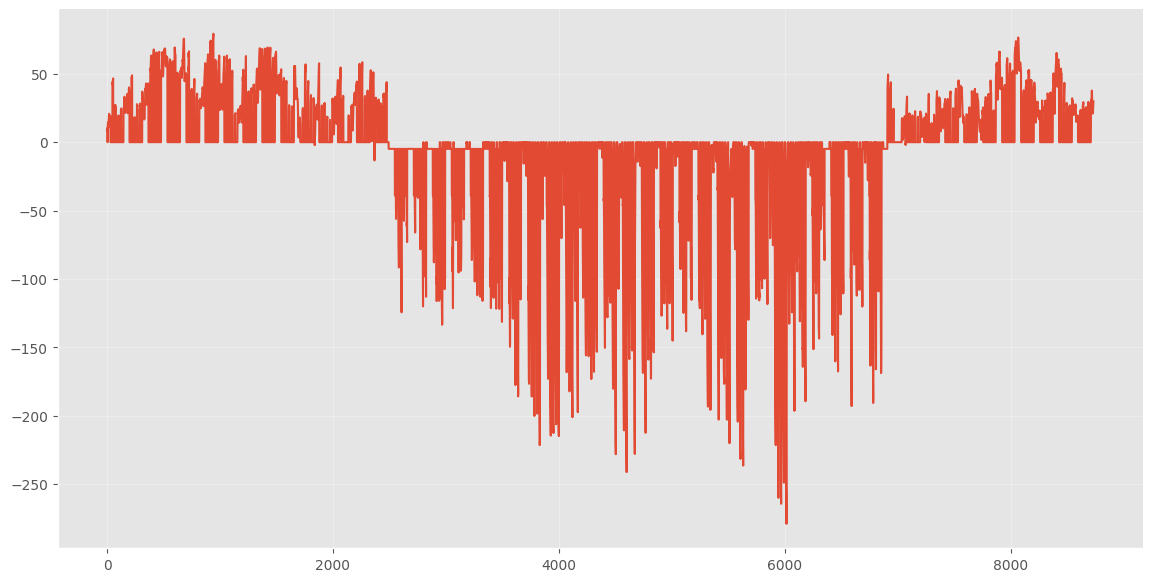

In [ ]:
plt.plot(X['aggregated_co'],label = 'Aggregated cons')
plt.plot(X.values[:,41::])

### Train/test *split*

Select the columns to be used as targets to be predicted ``(y, detailed consumptions)`` and the input columns ``(X, weather/aggregated consumptions)``.

In [ ]:
def select_xy(df, target):
    y = df[target]
    X = df.drop(columns=target)
    return X, y

Split data to ``separate train and test data``

In [ ]:
#X, y = select_xy(X,['batterie_froide_été_CTA_permanente_supp','batterie_froide_été_CTA_occupation_pos','besoin_froid_v1','besoin_froid_v2','besoin_v3','co_reduit_sup'])
X, y = select_xy(X,["Temperature de l'air"])

In [ ]:
X.head()

Humidite relative de l'air exterieur  \
0                                  48.0   
1                                  50.0   
2                                  54.0   
3                                  57.0   
4                                  58.0   

   Pression de vapeur saturante de l'air extérieur  \
0                                      1733.899764   
1                                      1722.778375   
2                                      1678.917290   
3                                      1678.917290   
4                                      1668.106634   

   Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
0                                         832.271887                         
1                                         861.389188                         
2                                         906.615337                         
3                                         956.982855                         
4                                         967.501848                         

   humidité absolue de l'air extérieur kge/kggas (re)  \
0                                           0.005176    
1                                           0.005359    
2                                           0.005643    
3                                           0.005959    
4                                           0.006025    

   enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
0                           28.380426                             0.827139   
1                           28.740721                             0.827093   
2                           29.052076                             0.826319   
3                           29.852106                             0.826735   
4                           29.917587                             0.826535   

   température intérieure en été et en hiver sans ralenti selon calendier clim    tih et tié  \
0                                               22.0                                           
1                                               22.0                                           
2                                               22.0                                           
3                                               22.0                                           
4                                               22.0                                           

      S  pression de vapeur saturante été et hiver sans ralenti  \
0  55.0                                        2655.099984        
1  55.0                                        2655.099984        
2  55.0                                        2655.099984        
3  55.0                                        2655.099984        
4  55.0                                        2655.099984        

   Humidité absolue de l'air intérieur été et hiver sans ralenti  ...  \
0                                           0.009139              ...   
1                                           0.009139              ...   
2                                           0.009139              ...   
3                                           0.009139              ...   
4                                           0.009139              ...   

   Humidité absolue de l'air intérieure été et hiver avec ralenti( ri)  \
0                                           0.007109                     
1                                           0.007109                     
2                                           0.007109                     
3                                           0.007109                     
4                                           0.007109                     

   enthalpie de l'air intérieur en hiver et en été et en confort et en ralenti  \
0                                          36.122623                             
1                                          36.122623                             
2                           

In [ ]:
y.head()

Temperature de l'air
0                  15.2
1                  15.1
2                  14.7
3                  14.7
4                  14.6

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [ ]:
X_train.head()

Humidite relative de l'air exterieur  \
0                                  48.0   
1                                  50.0   
2                                  54.0   
3                                  57.0   
4                                  58.0   

   Pression de vapeur saturante de l'air extérieur  \
0                                      1733.899764   
1                                      1722.778375   
2                                      1678.917290   
3                                      1678.917290   
4                                      1668.106634   

   Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
0                                         832.271887                         
1                                         861.389188                         
2                                         906.615337                         
3                                         956.982855                         
4                                         967.501848                         

   humidité absolue de l'air extérieur kge/kggas (re)  \
0                                           0.005176    
1                                           0.005359    
2                                           0.005643    
3                                           0.005959    
4                                           0.006025    

   enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
0                           28.380426                             0.827139   
1                           28.740721                             0.827093   
2                           29.052076                             0.826319   
3                           29.852106                             0.826735   
4                           29.917587                             0.826535   

   température intérieure en été et en hiver sans ralenti selon calendier clim    tih et tié  \
0                                               22.0                                           
1                                               22.0                                           
2                                               22.0                                           
3                                               22.0                                           
4                                               22.0                                           

      S  pression de vapeur saturante été et hiver sans ralenti  \
0  55.0                                        2655.099984        
1  55.0                                        2655.099984        
2  55.0                                        2655.099984        
3  55.0                                        2655.099984        
4  55.0                                        2655.099984        

   Humidité absolue de l'air intérieur été et hiver sans ralenti  ...  \
0                                           0.009139              ...   
1                                           0.009139              ...   
2                                           0.009139              ...   
3                                           0.009139              ...   
4                                           0.009139              ...   

   Humidité absolue de l'air intérieure été et hiver avec ralenti( ri)  \
0                                           0.007109                     
1                                           0.007109                     
2                                           0.007109                     
3                                           0.007109                     
4                                           0.007109                     

   enthalpie de l'air intérieur en hiver et en été et en confort et en ralenti  \
0                                          36.122623                             
1                                          36.122623                             
2                           

In [ ]:
y_train.head()

Temperature de l'air
0                  15.2
1                  15.1
2                  14.7
3                  14.7
4                  14.6

In [ ]:
X_test

Temperature de l'air  Humidite relative de l'air exterieur  \
6551                  15.5                                  86.0   
6552                  14.9                                  85.0   
6553                  14.0                                  89.0   
6554                  13.6                                  89.0   
6555                  13.0                                  93.0   
...                    ...                                   ...   
8730                  11.4                                  82.0   
8731                  10.8                                  79.0   
8732                  10.0                                  81.0   
8733                  10.0                                  80.0   
8734                   9.3                                  84.0   

      Pression de vapeur saturante de l'air extérieur  \
6551                                      1767.643462   
6552                                      1700.723541   
6553                                      1604.518606   
6554                                      1563.320282   
6555                                      1503.267311   
...                                               ...   
8730                                      1352.935446   
8731                                      1300.073269   
8732                                      1232.424756   
8733                                      1232.424756   
8734                                      1175.797474   

      Pression partielle  de vapeur avec humidité relative de l'air extérieur  \
6551                                        1520.173378                         
6552                                        1445.615010                         
6553                                        1428.021559                         
6554                                        1391.355051                         
6555                                        1398.038599                         
...                                                 ...                         
8730                                        1109.407066                         
8731                                        1027.057883                         
8732                                         998.264052                         
8733                                         985.939804                         
8734                                         987.669878                         

      humidité absolue de l'air extérieur kge/kggas (re)  \
6551                                           0.009520    
6552                                           0.009046    
6553                                           0.008934    
6554                                           0.008702    
6555                                           0.008744    
...                                                 ...    
8730                                           0.006919    
8731                                           0.006400    
8732                                           0.006219    
8733                                           0.006141    
8734                                           0.006152    

      enthalpie de l'air extérieure hext  volume massique de l'air extérieure  \
6551                           39.671729                             0.833734   
6552                           37.860057                             0.831377   
6553                           36.657603                             0.828633   
6554                           35.661115                             0.827173   
6555                           35.154980                             0.825498   
...                                  ...                                  ...   
8730                           28.916528                             0.818507   
8731                           26.997433                             0.816107   
8732                           25.726725                             0.813573   


In [ ]:
y_test

batterie_froide_été_CTA_permanente_supp  \
6988                                   0.0001   
6989                                   0.0001   
6990                                   0.0001   
6991                                   0.0001   
6992                                   0.0001   
...                                       ...   
8730                                   0.0001   
8731                                   0.0001   
8732                                   0.0001   
8733                                   0.0001   
8734                                   0.0001   

      batterie_froide_été_CTA_occupation_pos  besoins_froid_v1  \
6988                                  0.0001            0.0001   
6989                                  0.0001            0.0001   
6990                                  0.0001            0.0001   
6991                                  0.0001            0.0001   
6992                                  0.0001            0.0001   
...                                      ...               ...   
8730                                  0.0001            0.0001   
8731                                  0.0001            0.0001   
8732                                  0.0001            0.0001   
8733                                  0.0001            0.0001   
8734                                  0.0001            0.0001   

      besoin_froid_v2  besoins_v3  co_reduit_sup  
6988           0.0001      0.0001       0.000100  
6989           0.0001      0.0001       0.000100  
6990           0.0001      0.0001       0.000100  
6991           0.0001      0.0001       0.000100  
6992           0.0001      0.0001       0.000100  
...               ...         ...            ...  
8730           0.0001      0.0001      21.635160  
8731           0.0001      0.0001      24.135225  
8732           0.0001      0.0001      27.197045  
8733           0.0001      0.0001      27.238231  
8734           0.0001      0.0001      29.827245  

[1747 rows x 6 columns]

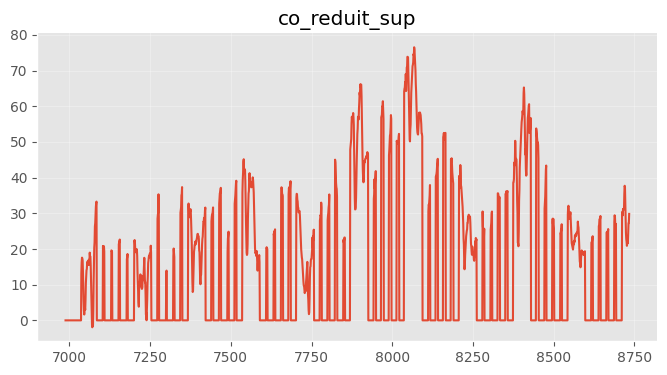

In [ ]:
# @title co_reduit_sup

from matplotlib import pyplot as plt
y_test['co_reduit_sup'].plot(kind='line', figsize=(8, 4), title='co_reduit_sup')
plt.gca().spines[['top', 'right']].set_visible(False)

### Scale and load data

In [ ]:
def get_scaler(scaler):
    scalers = {"minmax": MinMaxScaler,"standard": StandardScaler}
    return scalers.get(scaler.lower())()

In [ ]:
scaler = get_scaler('minmax')
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
y_train_sc = scaler.fit_transform(y_train)
y_test_sc = scaler.transform(y_test)

In [ ]:
batch_size = 24

train_X = torch.Tensor(X_train_sc)
train_y = torch.Tensor(y_train_sc)
test_X = torch.Tensor(X_test_sc)
test_y = torch.Tensor(y_test_sc)

train = TensorDataset(train_X, train_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
X_train_sc

array([[0.32, 0.25, 0.22, ..., 1.  , 1.  , 0.8 ],
       [0.34, 0.25, 0.23, ..., 1.  , 1.  , 0.8 ],
       [0.4 , 0.24, 0.25, ..., 1.  , 1.  , 0.81],
       ...,
       [0.6 , 0.33, 0.5 , ..., 1.  , 1.  , 0.78],
       [0.68, 0.3 , 0.51, ..., 1.  , 1.  , 0.78],
       [0.75, 0.28, 0.51, ..., 1.  , 1.  , 0.78]])

In [ ]:
y_train_sc

tensor([[0.5075],
        [0.5050],
        [0.4950],
        ...,
        [0.5920],
        [0.5647],
        [0.5373]])

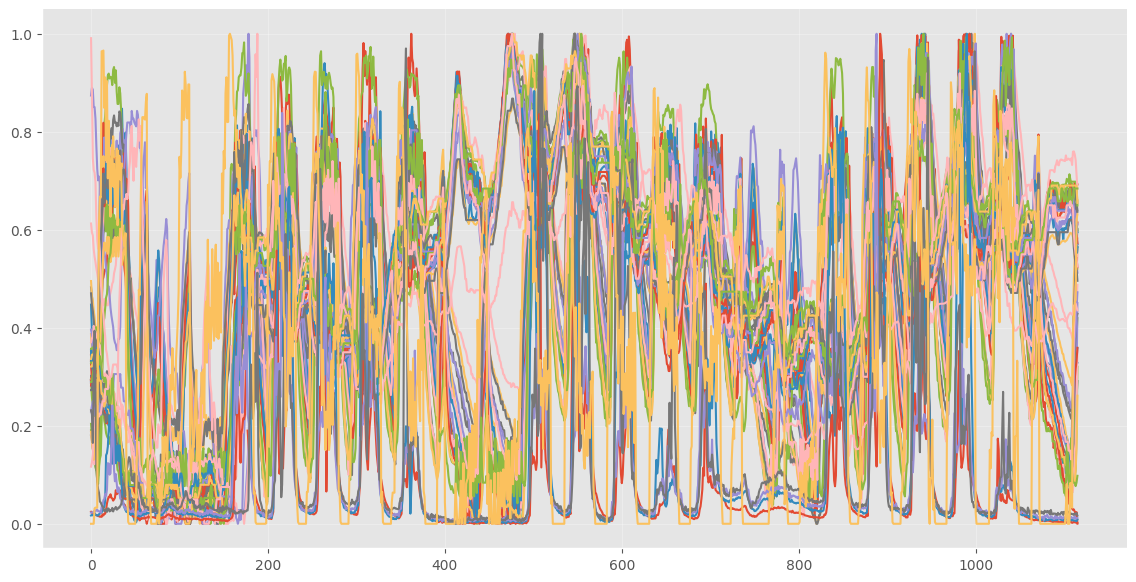

In [ ]:
plt.plot(X_train_sc);

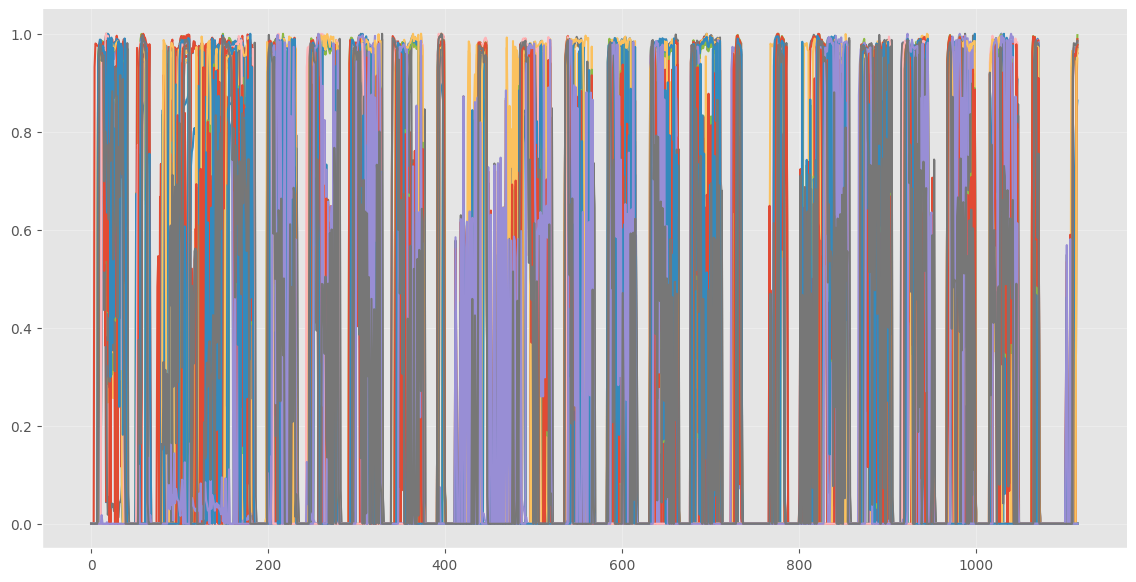

In [ ]:
plt.plot(y_train_sc);

## <font color=darkred> Boulogne data</font>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Power

In [ ]:
df_samples = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NILM/output.xlsx')
#df_samples = pd.read_excel("https://raw.githubusercontent.com/jeremiedecock/ateliers-algos/main/seq12/output.xlsx")
df = df_samples.drop(columns =['time'])
df = df.drop(df.iloc[:,0:1],axis=1)
df.head()

power_0x04cd15fffe7ccbc8  power_0x04cd15fffe7ccbe2  \
0                  0.985507                       1.0   
1                  1.000000                       1.0   
2                  0.985075                       1.0   
3                  1.000000                       1.0   
4                  0.955882                       1.0   

   power_0x086bd7fffeb67f5c  power_0x086bd7fffeb67f66  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   power_0x086bd7fffeb67f67  power_0x60a423fffe6ad593  \
0                  0.828947                       1.0   
1                  0.776316                       1.0   
2                  0.828947                       1.0   
3                  0.887324                       1.0   
4                  0.914286                       1.0   

   power_0x60a423fffe6ad63b  power_0x60a423fffe6ad64f  \
0                  1.000000                       1.0   
1                  1.000000                       1.0   
2                  1.000000                       1.0   
3                  1.000000                       1.0   
4                  0.985507                       1.0   

   power_0x60a423fffe6ad7ab  power_0x60a423fffe6ad7b6  ...  \
0                       1.0                  1.000000  ...   
1                       1.0                  0.985075  ...   
2                       1.0                  0.984375  ...   
3                       1.0                  1.000000  ...   
4                       1.0                  1.000000  ...   

   power_0x60a423fffe6add51  power_0x60a423fffe6add5e  \
0                       1.0                       0.0   
1                       1.0                       0.0   
2                       1.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   

   power_0x60a423fffe6add64  power_0x60a423fffe6add69  \
0                       0.0                       1.0   
1                       0.0                       1.0   
2                       0.0                       1.0   
3                       0.0                       1.0   
4                       0.0                       1.0   

   power_0x60a423fffe6add6f  power_0x680ae2fffe3efb4b  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   power_0x8cf681fffea3e03b  power_0x8cf681fffea7b209  \
0                       1.0                  0.984615   
1                       1.0                  0.984375   
2                       1.0                  0.985075   
3                       1.0                  1.000000   
4                       1.0                  1.000000   

   power_0x8cf681fffea7b20c  power_0x8cf681fffea7b268  
0                       1.0                       0.0  
1                       1.0                       0.0  
2                       1.0                       0.0  
3                       1.0                       0.0  
4                       1.0                       0.0  

[5 rows x 32 columns]

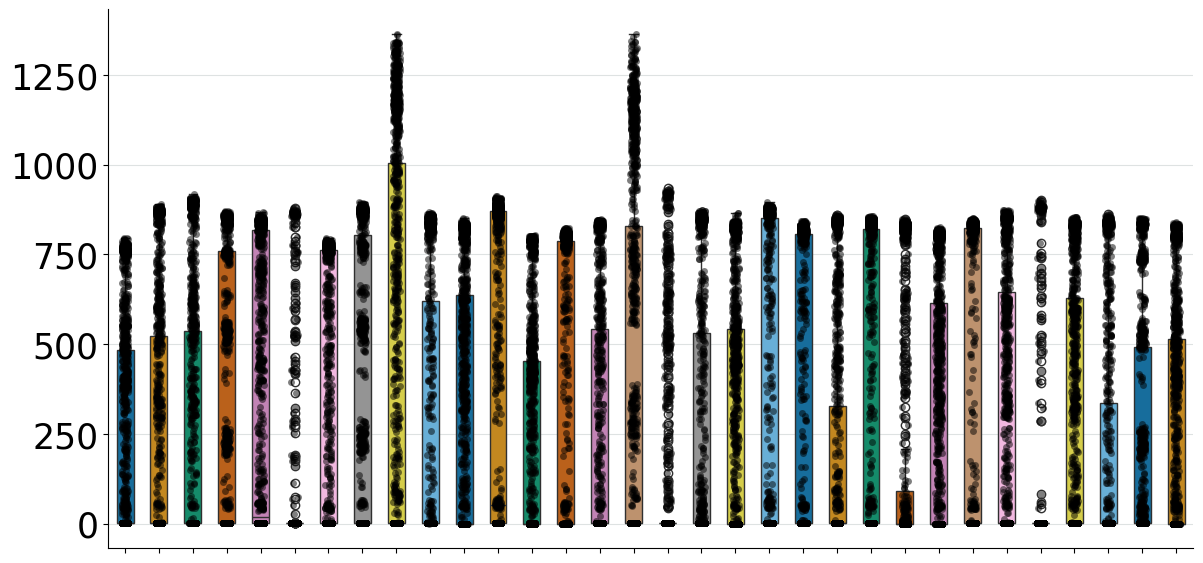

In [ ]:
bplot=sns.boxplot(data=df,
                 width=0.5,
                 palette="colorblind")
bplot=sns.stripplot(data=df,
                   jitter=True,
                   marker='o',
                   alpha=0.5,
                   color='black')
bplot.set(xticklabels=[]);

### CO2

In [ ]:
df_samples = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NILM/co2.xlsx')
#df_samples = pd.read_excel("https://raw.githubusercontent.com/jeremiedecock/ateliers-algos/main/seq12/co2.xlsx")
co2 = df_samples.drop(columns =['time'])
co2 = co2.drop(co2.iloc[:,0:1],axis=1)
co2.head()

co2_a81758fffe06267a  co2_a81758fffe062bc3  co2_a81758fffe066932  \
0            461.666667            413.000000            416.666667   
1            455.000000            415.000000            416.000000   
2            455.666667            413.333333            417.333333   
3            447.333333            414.000000            420.000000   
4            443.000000            421.000000            422.000000   

   co2_a81758fffe066933  
0            639.000000  
1            629.333333  
2            565.333333  
3            711.000000  
4            818.666667

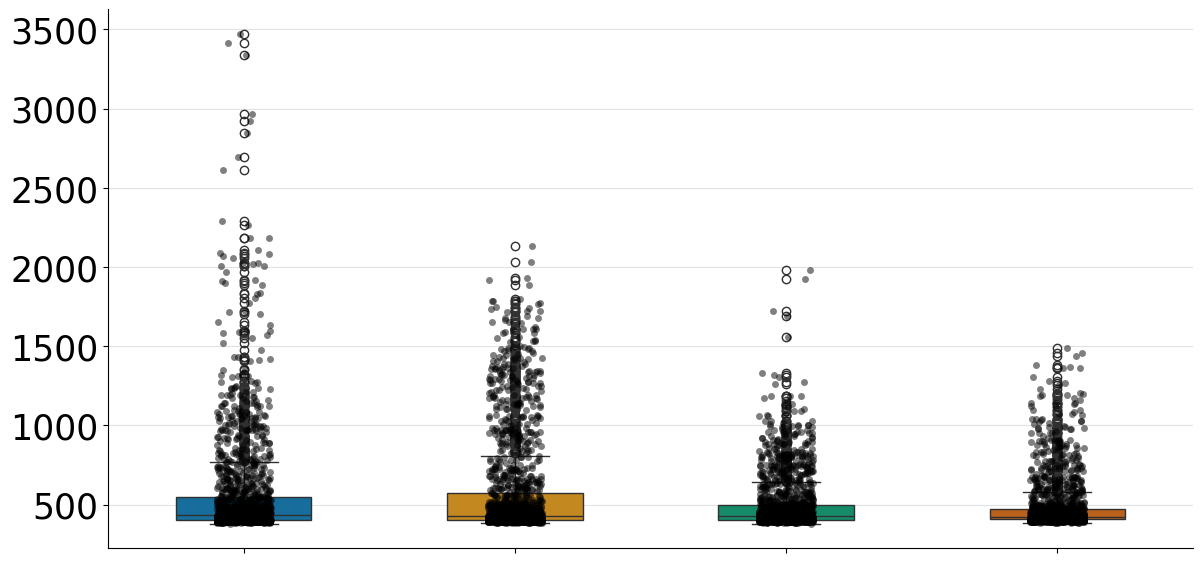

In [ ]:
bplot=sns.boxplot(data=co2,
                 width=0.5,
                 palette="colorblind")
bplot=sns.stripplot(data=co2,
                   jitter=True,
                   marker='o',
                   alpha=0.5,
                   color='black')
bplot.set(xticklabels=[]);

### Humidity

In [ ]:
df_samples = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NILM/hum.xlsx')
#df_samples = pd.read_excel("https://raw.githubusercontent.com/jeremiedecock/ateliers-algos/main/seq12/hum.xlsx")
hum = df_samples.drop(columns =['time'])
hum = hum.drop(hum.iloc[:,0:1],axis=1)
hum.head()

humidity_0x00124b00251c04e8  humidity_0x00124b00251c6341  \
0                    42.050000                    40.648000   
1                    42.405000                    41.260000   
2                    42.363333                    41.270000   
3                    42.700000                    41.490000   
4                    43.366000                    41.656667   

   humidity_0x00124b00251c689d  humidity_0x00124b00251c6b40  \
0                        41.91                        43.86   
1                        41.91                        44.29   
2                        42.43                        44.29   
3                        42.43                        44.81   
4                        42.95                        44.81   

   humidity_0x00124b00251c7606  humidity_0x00124b00251c7655  \
0                        42.67                        46.81   
1                        42.67                        46.81   
2                        43.10                        46.91   
3                        43.10                        46.91   
4                        43.32                        47.46   

   humidity_0x00124b00251c7934  humidity_0x00124b00251c9202  \
0                        48.51                        40.10   
1                        48.41                        40.41   
2                        48.31                        40.41   
3                        48.22                        40.94   
4                        48.13                        40.94   

   humidity_0x00124b00251fc44b  humidity_0x00124b00251fc461  ...  \
0                        41.51                    41.045000  ...   
1                        41.51                    41.136667  ...   
2                        41.71                    41.510000  ...   
3                        41.91                    41.710000  ...   
4                        42.33                    41.710000  ...   

   humidity_0x00124b00252126ae  humidity_0x00124b0025219df0  \
0                    42.900000                       41.280   
1                    42.900000                       41.540   
2                    42.920000                       41.805   
3                    43.286667                       42.070   
4                    44.020000                       42.270   

   humidity_0x00124b002521a0c8  humidity_a81758fffe04163d  \
0                    42.400000                       36.0   
1                    42.670000                       37.0   
2                    42.825000                       37.0   
3                    43.603333                       37.0   
4                    43.200000                       37.0   

   humidity_a81758fffe041760  humidity_a81758fffe061505  \
0                  37.000000                  33.250000   
1                  37.000000                  33.666667   
2                  37.000000                  34.000000   
3                  37.333333                  33.500000   
4                  38.000000                  33.000000   

   humidity_a81758fffe06267a  humidity_a81758fffe062bc3  \
0                       36.0                  36.666667   
1                       36.0                  37.000000   
2                       37.0                  37.000000   
3                       37.0                  37.000000   
4                       37.0                  37.333333   

   humidity_a81758fffe066932  humidity_a81758fffe066933  
0                  36.000000                  28.666667  
1                  36.000000                  29.000000  
2                  36.666667                  29.666667  
3                  37.000000                  31.500000  
4                  37.000000                  32.666667  

[5 rows x 21 columns]

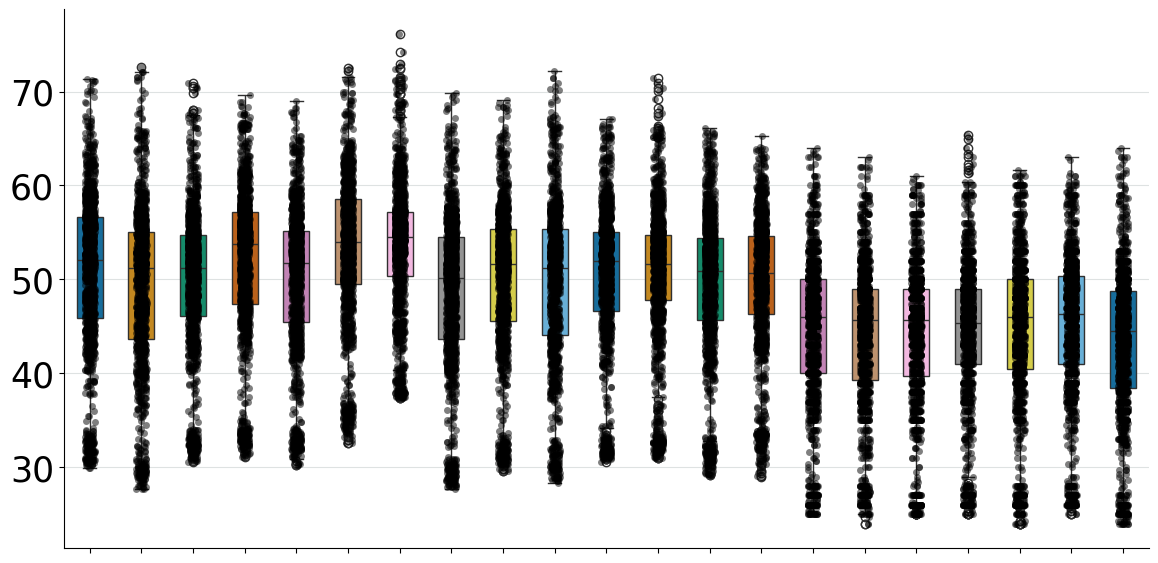

In [ ]:
bplot=sns.boxplot(data=hum,
                 width=0.5,
                 palette="colorblind")
bplot=sns.stripplot(data=hum,
                   jitter=True,
                   marker='o',
                   alpha=0.5,
                   color='black')
bplot.set(xticklabels=[]);

### Temperatures

In [ ]:
df_samples = pd.read_excel('/content/drive/My Drive/Colab Notebooks/NILM/temp.xlsx')
#df_samples = pd.read_excel("https://raw.githubusercontent.com/jeremiedecock/ateliers-algos/main/seq12/temp.xlsx")

temp = df_samples.drop(columns =['time'])
temp = temp.drop(temp.iloc[:,0:1],axis=1)
temp.head()

temperature_0x00124b00251c04e8  temperature_0x00124b00251c6341  \
0                          18.560                       18.662000   
1                          18.395                       18.420000   
2                          18.380                       18.408333   
3                          18.160                       18.280000   
4                          18.088                       18.221667   

   temperature_0x00124b00251c689d  temperature_0x00124b00251c6b40  \
0                         18.4075                          17.480   
1                         18.2600                          17.445   
2                         18.2000                          17.320   
3                         18.0300                          17.270   
4                         17.9800                          17.170   

   temperature_0x00124b00251c7606  temperature_0x00124b00251c7655  \
0                          18.475                       17.665000   
1                          18.340                       17.540000   
2                          18.305                       17.476667   
3                          18.170                       17.295000   
4                          18.125                       17.263333   

   temperature_0x00124b00251c7934  temperature_0x00124b00251c9202  \
0                       18.800000                          18.220   
1                       18.730000                          18.170   
2                       18.706667                          18.030   
3                       18.600000                          17.985   
4                       18.540000                          17.860   

   temperature_0x00124b00251fc44b  temperature_0x00124b00251fc461  ...  \
0                         18.3450                          18.530  ...   
1                         18.1700                          18.480  ...   
2                         18.1475                          18.200  ...   
3                         17.9900                          18.215  ...   
4                         17.9450                          17.990  ...   

   temperature_0x00124b00252126ae  temperature_0x00124b0025219df0  \
0                       18.580000                           17.84   
1                       18.410000                           17.71   
2                       18.370000                           17.62   
3                       18.256667                           17.52   
4                       18.180000                           17.63   

   temperature_0x00124b002521a0c8  temperature_a81758fffe04163d  \
0                       17.630000                     18.333333   
1                       17.510000                     18.200000   
2                       17.440000                     18.066667   
3                       17.342222                     17.900000   
4                       17.260000                     17.900000   

   temperature_a81758fffe041760  temperature_a81758fffe061505  \
0                     18.433333                     20.500000   
1                     18.333333                     20.566667   
2                     18.233333                     20.550000   
3                     18.133333                     20.400000   
4                     18.066667                     20.400000   

   temperature_a81758fffe06267a  temperature_a81758fffe062bc3  \
0                     18.833333                     17.600000   
1                     18.700000                     17.500000   
2                     18.633333                     17.400000   
3                     18.533333                     17.266667   
4                     18.433333                     17.366667   

   temperature_a81758fffe066932  temperature_a81758fffe066933  
0                     17.866667                     21.800000  
1                     17.733333                     21.166667  
2                     17.633333                     20.433333  
3                     17.600000           

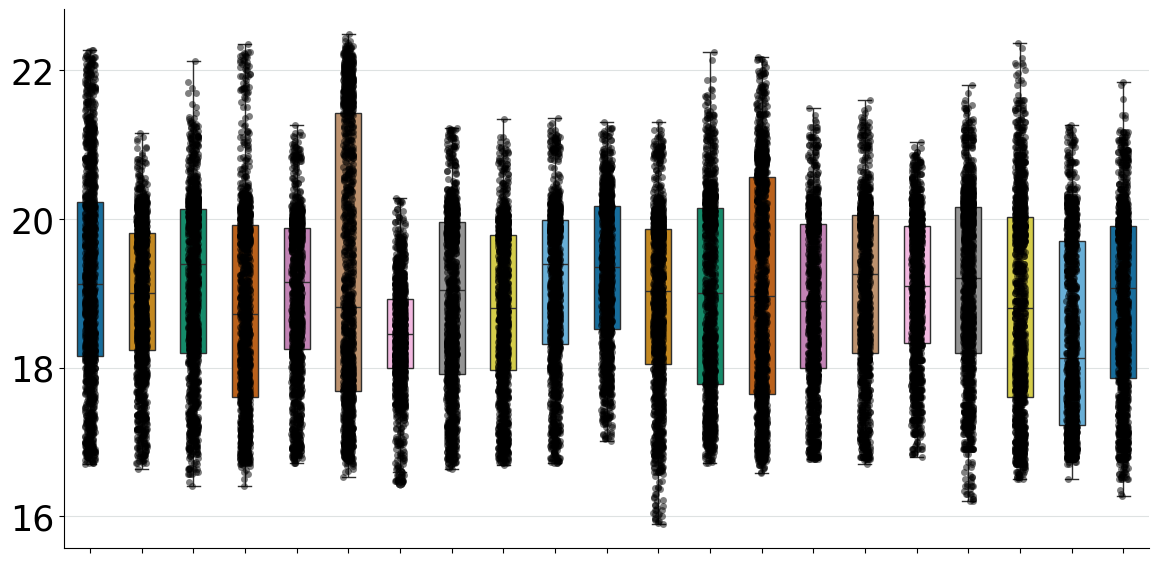

In [ ]:
bplot=sns.boxplot(data=temp,
                 width=0.5,
                 palette="colorblind")
bplot=sns.stripplot(data=temp,
                   jitter=True,
                   marker='o',
                   alpha=0.5,
                   color='black')
bplot.set(xticklabels=[]);

In [ ]:
input = pd.concat([temp,hum,co2], axis=1)
input.head()

temperature_0x00124b00251c04e8  temperature_0x00124b00251c6341  \
0                          18.560                       18.662000   
1                          18.395                       18.420000   
2                          18.380                       18.408333   
3                          18.160                       18.280000   
4                          18.088                       18.221667   

   temperature_0x00124b00251c689d  temperature_0x00124b00251c6b40  \
0                         18.4075                          17.480   
1                         18.2600                          17.445   
2                         18.2000                          17.320   
3                         18.0300                          17.270   
4                         17.9800                          17.170   

   temperature_0x00124b00251c7606  temperature_0x00124b00251c7655  \
0                          18.475                       17.665000   
1                          18.340                       17.540000   
2                          18.305                       17.476667   
3                          18.170                       17.295000   
4                          18.125                       17.263333   

   temperature_0x00124b00251c7934  temperature_0x00124b00251c9202  \
0                       18.800000                          18.220   
1                       18.730000                          18.170   
2                       18.706667                          18.030   
3                       18.600000                          17.985   
4                       18.540000                          17.860   

   temperature_0x00124b00251fc44b  temperature_0x00124b00251fc461  ...  \
0                         18.3450                          18.530  ...   
1                         18.1700                          18.480  ...   
2                         18.1475                          18.200  ...   
3                         17.9900                          18.215  ...   
4                         17.9450                          17.990  ...   

   humidity_a81758fffe041760  humidity_a81758fffe061505  \
0                  37.000000                  33.250000   
1                  37.000000                  33.666667   
2                  37.000000                  34.000000   
3                  37.333333                  33.500000   
4                  38.000000                  33.000000   

   humidity_a81758fffe06267a  humidity_a81758fffe062bc3  \
0                       36.0                  36.666667   
1                       36.0                  37.000000   
2                       37.0                  37.000000   
3                       37.0                  37.000000   
4                       37.0                  37.333333   

   humidity_a81758fffe066932  humidity_a81758fffe066933  co2_a81758fffe06267a  \
0                  36.000000                  28.666667            461.666667   
1                  36.000000                  29.000000            455.000000   
2                  36.666667                  29.666667            455.666667   
3                  37.000000                  31.500000            447.333333   
4                  37.000000                  32.666667            443.000000   

   co2_a81758fffe062bc3  co2_a81758fffe066932  co2_a81758fffe066933  
0            413.000000            416.666667            639.000000  
1            415.000000            416.000000            629.333333  
2            413.333333            417.333333            565.333333  
3            414.000000            420.000000            711.000000  
4            421.000000            422.000000            818.666667  

[5 rows x 46 columns]

In [ ]:
input['aggregated_co'] = df.sum(axis=1)
input.head()

temperature_0x00124b00251c04e8  temperature_0x00124b00251c6341  \
0                          18.560                       18.662000   
1                          18.395                       18.420000   
2                          18.380                       18.408333   
3                          18.160                       18.280000   
4                          18.088                       18.221667   

   temperature_0x00124b00251c689d  temperature_0x00124b00251c6b40  \
0                         18.4075                          17.480   
1                         18.2600                          17.445   
2                         18.2000                          17.320   
3                         18.0300                          17.270   
4                         17.9800                          17.170   

   temperature_0x00124b00251c7606  temperature_0x00124b00251c7655  \
0                          18.475                       17.665000   
1                          18.340                       17.540000   
2                          18.305                       17.476667   
3                          18.170                       17.295000   
4                          18.125                       17.263333   

   temperature_0x00124b00251c7934  temperature_0x00124b00251c9202  \
0                       18.800000                          18.220   
1                       18.730000                          18.170   
2                       18.706667                          18.030   
3                       18.600000                          17.985   
4                       18.540000                          17.860   

   temperature_0x00124b00251fc44b  temperature_0x00124b00251fc461  ...  \
0                         18.3450                          18.530  ...   
1                         18.1700                          18.480  ...   
2                         18.1475                          18.200  ...   
3                         17.9900                          18.215  ...   
4                         17.9450                          17.990  ...   

   humidity_a81758fffe061505  humidity_a81758fffe06267a  \
0                  33.250000                       36.0   
1                  33.666667                       36.0   
2                  34.000000                       37.0   
3                  33.500000                       37.0   
4                  33.000000                       37.0   

   humidity_a81758fffe062bc3  humidity_a81758fffe066932  \
0                  36.666667                  36.000000   
1                  37.000000                  36.000000   
2                  37.000000                  36.666667   
3                  37.000000                  37.000000   
4                  37.333333                  37.000000   

   humidity_a81758fffe066933  co2_a81758fffe06267a  co2_a81758fffe062bc3  \
0                  28.666667            461.666667            413.000000   
1                  29.000000            455.000000            415.000000   
2                  29.666667            455.666667            413.333333   
3                  31.500000            447.333333            414.000000   
4                  32.666667            443.000000            421.000000   

   co2_a81758fffe066932  co2_a81758fffe066933  aggregated_co  
0            416.666667            639.000000      24.770084  
1            416.000000            629.333333      24.745765  
2            417.333333            565.333333      24.783472  
3            420.000000            711.000000      24.887324  
4            422.000000            818.666667     825.031036  

[5 rows x 47 columns]

In [ ]:
full_data = pd.concat([input,df], axis=1)
full_data.head()

temperature_0x00124b00251c04e8  temperature_0x00124b00251c6341  \
0                          18.560                       18.662000   
1                          18.395                       18.420000   
2                          18.380                       18.408333   
3                          18.160                       18.280000   
4                          18.088                       18.221667   

   temperature_0x00124b00251c689d  temperature_0x00124b00251c6b40  \
0                         18.4075                          17.480   
1                         18.2600                          17.445   
2                         18.2000                          17.320   
3                         18.0300                          17.270   
4                         17.9800                          17.170   

   temperature_0x00124b00251c7606  temperature_0x00124b00251c7655  \
0                          18.475                       17.665000   
1                          18.340                       17.540000   
2                          18.305                       17.476667   
3                          18.170                       17.295000   
4                          18.125                       17.263333   

   temperature_0x00124b00251c7934  temperature_0x00124b00251c9202  \
0                       18.800000                          18.220   
1                       18.730000                          18.170   
2                       18.706667                          18.030   
3                       18.600000                          17.985   
4                       18.540000                          17.860   

   temperature_0x00124b00251fc44b  temperature_0x00124b00251fc461  ...  \
0                         18.3450                          18.530  ...   
1                         18.1700                          18.480  ...   
2                         18.1475                          18.200  ...   
3                         17.9900                          18.215  ...   
4                         17.9450                          17.990  ...   

   power_0x60a423fffe6add51  power_0x60a423fffe6add5e  \
0                       1.0                       0.0   
1                       1.0                       0.0   
2                       1.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   

   power_0x60a423fffe6add64  power_0x60a423fffe6add69  \
0                       0.0                       1.0   
1                       0.0                       1.0   
2                       0.0                       1.0   
3                       0.0                       1.0   
4                       0.0                       1.0   

   power_0x60a423fffe6add6f  power_0x680ae2fffe3efb4b  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   power_0x8cf681fffea3e03b  power_0x8cf681fffea7b209  \
0                       1.0                  0.984615   
1                       1.0                  0.984375   
2                       1.0                  0.985075   
3                       1.0                  1.000000   
4                       1.0                  1.000000   

   power_0x8cf681fffea7b20c  power_0x8cf681fffea7b268  
0                       1.0                       0.0  
1                       1.0                       0.0  
2                       1.0                       0.0  
3                       1.0                       0.0  
4                       1.0                       0.0  

[5 rows x 79 columns]

### Train/test *split*

Select the columns to be used as targets to be predicted ``(y, detailed consumptions)`` and the input columns ``(X, weather/aggregated consumptions)``.

In [ ]:
X = input
X.shape

(1488, 47)

In [ ]:
y = df
y.shape

(1488, 32)

In [ ]:
X.isnull().sum().sum()

7

In [ ]:
X = X.fillna(X.mean())

In [ ]:
y.isnull().sum().sum()

0

In [ ]:
y = y.fillna(y.mean())

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False)

In [ ]:
X_train.head()

temperature_0x00124b00251c04e8  temperature_0x00124b00251c6341  \
0                          18.560                       18.662000   
1                          18.395                       18.420000   
2                          18.380                       18.408333   
3                          18.160                       18.280000   
4                          18.088                       18.221667   

   temperature_0x00124b00251c689d  temperature_0x00124b00251c6b40  \
0                         18.4075                          17.480   
1                         18.2600                          17.445   
2                         18.2000                          17.320   
3                         18.0300                          17.270   
4                         17.9800                          17.170   

   temperature_0x00124b00251c7606  temperature_0x00124b00251c7655  \
0                          18.475                       17.665000   
1                          18.340                       17.540000   
2                          18.305                       17.476667   
3                          18.170                       17.295000   
4                          18.125                       17.263333   

   temperature_0x00124b00251c7934  temperature_0x00124b00251c9202  \
0                       18.800000                          18.220   
1                       18.730000                          18.170   
2                       18.706667                          18.030   
3                       18.600000                          17.985   
4                       18.540000                          17.860   

   temperature_0x00124b00251fc44b  temperature_0x00124b00251fc461  ...  \
0                         18.3450                          18.530  ...   
1                         18.1700                          18.480  ...   
2                         18.1475                          18.200  ...   
3                         17.9900                          18.215  ...   
4                         17.9450                          17.990  ...   

   humidity_a81758fffe061505  humidity_a81758fffe06267a  \
0                  33.250000                       36.0   
1                  33.666667                       36.0   
2                  34.000000                       37.0   
3                  33.500000                       37.0   
4                  33.000000                       37.0   

   humidity_a81758fffe062bc3  humidity_a81758fffe066932  \
0                  36.666667                  36.000000   
1                  37.000000                  36.000000   
2                  37.000000                  36.666667   
3                  37.000000                  37.000000   
4                  37.333333                  37.000000   

   humidity_a81758fffe066933  co2_a81758fffe06267a  co2_a81758fffe062bc3  \
0                  28.666667            461.666667            413.000000   
1                  29.000000            455.000000            415.000000   
2                  29.666667            455.666667            413.333333   
3                  31.500000            447.333333            414.000000   
4                  32.666667            443.000000            421.000000   

   co2_a81758fffe066932  co2_a81758fffe066933  aggregated_co  
0            416.666667            639.000000      24.770084  
1            416.000000            629.333333      24.745765  
2            417.333333            565.333333      24.783472  
3            420.000000            711.000000      24.887324  
4            422.000000            818.666667     825.031036  

[5 rows x 47 columns]

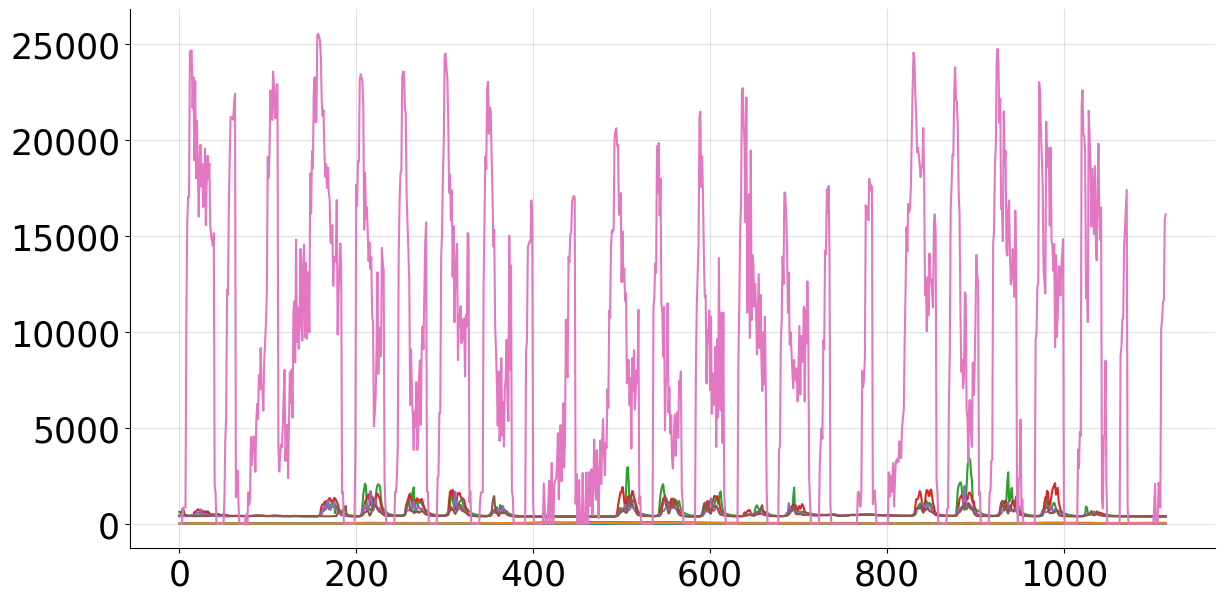

In [ ]:
plt.plot(X_train);

In [ ]:
y_train.head()

power_0x04cd15fffe7ccbc8  power_0x04cd15fffe7ccbe2  \
0                  0.985507                       1.0   
1                  1.000000                       1.0   
2                  0.985075                       1.0   
3                  1.000000                       1.0   
4                  0.955882                       1.0   

   power_0x086bd7fffeb67f5c  power_0x086bd7fffeb67f66  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   power_0x086bd7fffeb67f67  power_0x60a423fffe6ad593  \
0                  0.828947                       1.0   
1                  0.776316                       1.0   
2                  0.828947                       1.0   
3                  0.887324                       1.0   
4                  0.914286                       1.0   

   power_0x60a423fffe6ad63b  power_0x60a423fffe6ad64f  \
0                  1.000000                       1.0   
1                  1.000000                       1.0   
2                  1.000000                       1.0   
3                  1.000000                       1.0   
4                  0.985507                       1.0   

   power_0x60a423fffe6ad7ab  power_0x60a423fffe6ad7b6  ...  \
0                       1.0                  1.000000  ...   
1                       1.0                  0.985075  ...   
2                       1.0                  0.984375  ...   
3                       1.0                  1.000000  ...   
4                       1.0                  1.000000  ...   

   power_0x60a423fffe6add51  power_0x60a423fffe6add5e  \
0                       1.0                       0.0   
1                       1.0                       0.0   
2                       1.0                       0.0   
3                       1.0                       0.0   
4                       1.0                       0.0   

   power_0x60a423fffe6add64  power_0x60a423fffe6add69  \
0                       0.0                       1.0   
1                       0.0                       1.0   
2                       0.0                       1.0   
3                       0.0                       1.0   
4                       0.0                       1.0   

   power_0x60a423fffe6add6f  power_0x680ae2fffe3efb4b  \
0                       1.0                       1.0   
1                       1.0                       1.0   
2                       1.0                       1.0   
3                       1.0                       1.0   
4                       1.0                       1.0   

   power_0x8cf681fffea3e03b  power_0x8cf681fffea7b209  \
0                       1.0                  0.984615   
1                       1.0                  0.984375   
2                       1.0                  0.985075   
3                       1.0                  1.000000   
4                       1.0                  1.000000   

   power_0x8cf681fffea7b20c  power_0x8cf681fffea7b268  
0                       1.0                       0.0  
1                       1.0                       0.0  
2                       1.0                       0.0  
3                       1.0                       0.0  
4                       1.0                       0.0  

[5 rows x 32 columns]

In [ ]:
y_train.shape

(1116, 32)

### Scale and load data

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)
y_train_sc = scaler.fit_transform(y_train)
y_test_sc = scaler.transform(y_test)

### Build time series batches

In [ ]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index:index+self.seq_len])

In [ ]:
# Data sampled every 1/2 hour
train_dataset = TSDataset(torch.Tensor(X_train_sc), torch.Tensor(y_train_sc), seq_len=48)
test_dataset = TSDataset(torch.Tensor(X_test_sc), torch.Tensor(y_test_sc), seq_len=48)

In [ ]:
batch_size = 12
seq_len = 48
n_features = 47
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test_dataset, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
for i, d in enumerate(test_loader):
    print(i, d[0].shape, d[1].shape)

0 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
1 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
2 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
3 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
4 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
5 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
6 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
7 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
8 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
9 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
10 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
11 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
12 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
13 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
14 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
15 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
16 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
17 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
18 torch.Size([12, 48, 47]) torch.Size([12, 48, 32])
19 

### Independent batches

In [ ]:
batch_size = 12

train_X = torch.Tensor(X_train_sc)
train_y = torch.Tensor(y_train_sc)
test_X = torch.Tensor(X_test_sc)
test_y = torch.Tensor(y_test_sc)

train = TensorDataset(train_X, train_y)
test = TensorDataset(test_X, test_y)

train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader_one = DataLoader(test, batch_size=1, shuffle=False, drop_last=True)

In [ ]:
for i, d in enumerate(train_loader):
    print(i, d[0].shape, d[1].shape)

0 torch.Size([12, 47]) torch.Size([12, 32])
1 torch.Size([12, 47]) torch.Size([12, 32])
2 torch.Size([12, 47]) torch.Size([12, 32])
3 torch.Size([12, 47]) torch.Size([12, 32])
4 torch.Size([12, 47]) torch.Size([12, 32])
5 torch.Size([12, 47]) torch.Size([12, 32])
6 torch.Size([12, 47]) torch.Size([12, 32])
7 torch.Size([12, 47]) torch.Size([12, 32])
8 torch.Size([12, 47]) torch.Size([12, 32])
9 torch.Size([12, 47]) torch.Size([12, 32])
10 torch.Size([12, 47]) torch.Size([12, 32])
11 torch.Size([12, 47]) torch.Size([12, 32])
12 torch.Size([12, 47]) torch.Size([12, 32])
13 torch.Size([12, 47]) torch.Size([12, 32])
14 torch.Size([12, 47]) torch.Size([12, 32])
15 torch.Size([12, 47]) torch.Size([12, 32])
16 torch.Size([12, 47]) torch.Size([12, 32])
17 torch.Size([12, 47]) torch.Size([12, 32])
18 torch.Size([12, 47]) torch.Size([12, 32])
19 torch.Size([12, 47]) torch.Size([12, 32])
20 torch.Size([12, 47]) torch.Size([12, 32])
21 torch.Size([12, 47]) torch.Size([12, 32])
22 torch.Size([12, 4

In [ ]:
X_train_sc.shape

(1116, 47)

In [ ]:
y_train_sc

array([[-0.8 , -0.68, -0.68, ..., -0.63, -0.6 , -0.82],
       [-0.8 , -0.68, -0.68, ..., -0.63, -0.6 , -0.82],
       [-0.8 , -0.68, -0.68, ..., -0.63, -0.6 , -0.82],
       ...,
       [ 1.83,  1.97,  1.97, ..., -0.63, -0.6 ,  1.79],
       [ 1.79,  2.01,  2.02, ..., -0.63, -0.6 ,  1.8 ],
       [ 1.81,  2.02,  2.03, ..., -0.63, -0.6 ,  1.81]])

## <font color=darkred> RNN model</font>

We want to build a neural network specifically designed to process an input sequence $x_{1:T} = (x_1, ..., x_T)$ to predict an output sequence. Recurrent neural networks (RNNs) are designed to model dependencies for sequences of arbitrary length.

Consider a **supervised learning** task which aims to predict  $y_{1:T} = (y_1, ..., y_T )$ using the input $x_{1:T}$. A simple RNN layer writes, for $1\leq t \leq T$,
\begin{align*}
h_t &= \phi_h(W_hh_{t−1} + W_xx_t + b_h)\,,\\
y_t &= \phi_y(W_yh_t + b_y)\,.
\end{align*}
In this case, the latent states are the $(h_t)_{t\geq 0}$.

The unknown parameters are $\theta = \{W_h, W_x, W_y, b_h, b_y\}$, and $\phi_h$ and $\phi_y$ are the
 activation functions.

 Usually, the model is initialized with $h_0 = 0$.

A graphical model of a RNN.
![](https://www.researchgate.net/profile/Yassin-Khalifa-3/publication/346853926/figure/fig2/AS:1007113883119616@1617126069530/A-simple-RNN-with-a-single-hidden-layer-At-each-time-step-output-is-produced-through_W640.jpg)

![](https://raw.githubusercontent.com/kmkarakaya/Deep-Learning-Tutorials/master/images/LSTM_internal2.png)

In [ ]:
class RNNmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(RNNmodel, self).__init__()

        self.hidden_d = hidden_d
        self.layer_n = layer_n


        # TO DO:
        # Build inner layers of the recurrent model
        # Build output layer (for instance linear)

        self.rnn = nn.RNN(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)
        # Linear output for the regression problem
        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """

        # Forward pass
        out, h0 = self.rnn(x)#, h0.detach())

        out = self.fc(out)
        return out

## <font color=darkred> LSTM model</font>

In practice, even with the few tricks discussed before, RNN cannot model long-term dependencies. LSTMs also have a chain-like structure, composed of four interacting sublayers.

Writing $z_t = (h_{t-1},x_t)$, the LSTM cell writes:
\begin{align*}
f_t &= \sigma(W_f z_t + b_f)\,, \quad \mathrm{ forget\; gate}\,,\\
i_t &= \sigma(W_i z_t + b_i)\,, \quad \mathrm{ input\; gate}\,,\\
\tilde c_t &= \mathrm{tanh}(W_c z_t + b_c)\,\\
c_t &= f_t c_{t-1}+ i_t \tilde c_t\,,\\
o_t &= \sigma(W_o z_t + b_o)\,, \quad \mathrm{ output\; gate}\,,\\
h_t &= o_t\mathrm{tanh}( c_t)\,.
\end{align*}

A graphical model of a LSTM.
![](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/1280px-Peephole_Long_Short-Term_Memory.svg.png)

In [ ]:
class LSTMmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(LSTMmodel, self).__init__()

        self.hidden_d = hidden_d
        self.layer_d = layer_n

        # TO DO:
        # Build inner layers of the recurrent model
        # Build output layer (for instance linear)

        self.lstm = nn.LSTM(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)

        # Linear output for the regression problem
        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """

        # Forward pass
        out, (hn, cn) = self.lstm(x)

        out = self.fc(out)

        return out

## <font color=darkred> GRU model</font>

In [ ]:
class GRUmodel(nn.Module):
    def __init__(self, input_d, hidden_d, layer_n, output_d, dropout_p):
        """
        input_d (int): dimension of the input layer
        hidden_d (int): dimension of each layer
        layer_n (int): number of layers
        output_d (int): dimension of output layer
        dropout_p (float): probability of dropping neurons
        """
        super(GRUmodel, self).__init__()

        self.layer_n = layer_n
        self.hidden_d = hidden_d

        # TO DO:
        # Build inner layers of the recurrent model
        # Build output layer (for instance linear)
        self.gru = nn.GRU(input_d, hidden_d, layer_n, batch_first=True, dropout=dropout_p)

        # Linear output for the regression problem
        self.fc = nn.Linear(hidden_d, output_d)

    def forward(self, x):
        """
        x (torch.Tensor): input tensor (batch size, sequence length, input_d)
        """
        # Forward pass
        out, _ = self.gru(x)
        out = self.fc(out)

        return out

## <font color=darkred> Baselines</font>

### Ridge regression baselines

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors

**Problem**

It is assumed that for all $1\leqslant i \leqslant n$,

$$
Y_i = X^\top_i \beta_{\star} + \varepsilon_i\,,
$$

where the $(\varepsilon_i)_{1\leqslant i\leqslant n}$ are i.i.d. random variables in $\mathbb{R}$, $X_i\in\mathbb{R}^d$ and $\beta_{\star}$ is an unknown vector in $\mathbb{R}^d$. Let $Y\in\mathbb{R}^n$ (resp. $\varepsilon\in\mathbb{R}^n$)  be the random vector such that  for all $1\leqslant i \leqslant n$, the $i$-th component of $Y$ (resp. $\varepsilon$) is $Y_i$ (resp. $\varepsilon_i$) and $X\in\mathbb{R}^{n\times d}$ the matrix with line $i$ equal to $X^\top_i$. The model is then written

$$
Y = X \beta_{\star} + \varepsilon\,.
$$

In this section, it is assumed that $\mathbb{E}[\varepsilon] = 0$ and $\mathbb{E}[\varepsilon \varepsilon^\top] = \sigma_{\star}^2 I_n$. The penalized least squares estimate of $\beta_{\star}$ is defined as a solution to

$$
\widehat \beta_n\in  \mathrm{argmin}_{\beta\in\mathbb{R}^d}\,\left( \|Y - X\beta\|_2^2 + \lambda \|\beta\|_2^2\right)\,.
$$

where $\lambda>0$.

**Penalization**

The matrix $X^\top X + \lambda I_d$ is definite positive for all $\lambda>0$ as for all $u\in\mathbb{R}^d$,

$$
u^\top(X^\top X + \lambda I_d)u = \|Xu\|_2^2 + \lambda \|u\|_2^2\,,
$$

which is positive for all $u\neq 0$.

Therefore,  the matrix $X^\top X + \lambda I_d$ is invertible for all $\lambda>0$. Using that for all $\beta>0$,

$$
\nabla \left(\|Y - X\beta\|_2^2 + \lambda \|\beta\|_2^2\right) = 2X^\top X\beta - 2X^\top Y +  2\lambda\beta = 2\left\{\left(X^\top X + \lambda I_d\right)\beta -X^\top Y\right\}\,.
$$

Therefore,

$$
\widehat \beta_n = \left(X^\top X + \lambda I_d\right)^{-1}X^\top Y\,.
$$

**Bias**

Note first that $\mathbb{E}[Y] = X\beta_*$ which yields

$$
\mathbb{E}[\widehat \beta_n] = \left(X^\top X + \lambda I_d\right)^{-1}X^\top X\beta_*
$$

and

$$
\mathbb{E}[\widehat \beta_n] - \beta_* = \left(X^\top X + \lambda I_d\right)^{-1}X^\top X\beta_* - \beta_* = \left(X^\top X + \lambda I_d\right)^{-1}\left(X^\top X - \left(X^\top X + \lambda I_d\right)\right)\beta_* = - \lambda(X^\top X + \lambda I_d)^{-1}\beta_*\,.
$$

**Variance**

By definition of $\widehat\beta_n$,

$$
\mathbb{V}[\widehat \beta_n] = \left(X^TX + \lambda I_d\right)^{-1}X^T\mathbb{V}[Y]X\left(X^TX + \lambda I_d\right)^{-1} = \sigma_*^2\left(X^TX + \lambda I_d\right)^{-1}X^TX\left(X^TX + \lambda I_d\right)^{-1}\,,
$$

since $\mathbb{V}[Y] = \sigma_*^2 I_n$. Let $\lambda_1,\ldots,\lambda_d\geqslant 0$ be the eignevalues of $X^TX$. Then, there exits an orthogonal matrix $P$, such that

$$
X^\top X = P^{-1}\Delta P \quad\mathrm{and}\quad X^\top X + \lambda I_d = P^{-1}\tilde\Delta P\,,
$$

where $\Delta = \mathrm{diag}(\lambda_1,\ldots,\lambda_d)$ and $\tilde\Delta = \mathrm{diag}(\lambda_1 + \lambda,\ldots,\lambda_d+\lambda)$.

$$
\left(X^\top X + \lambda I_d\right)^{-1}X^\top X\left(X^\top X + \lambda I_d\right)^{-1} = P^{-1}\tilde\Delta^{-1} PP^{-1}\Delta PP^{-1}\tilde\Delta^{-1} P = P^{-1}\tilde\Delta^{-2}PP^{-1}\Delta P = \sigma_\star^2(X^\top X + \lambda I_d)^{-2}X^\top X\,.
$$

In [ ]:
from sklearn import linear_model
reg_lin = linear_model.Ridge(alpha= 0.0)

In [ ]:
reg_lin.fit(X_train_sc, y_train_sc)

Ridge(alpha=0.0)

In [ ]:
y_hat_lin = reg_lin.predict(X_train_sc)
y_hat_lin.shape

(1116, 32)

In [ ]:
y_train_sc.shape

(1116, 32)

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
MAE = mean_absolute_error(y_hat_lin,y_train_sc)
MSE = mean_squared_error(y_hat_lin,y_train_sc)
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.3898	 MSE: 0.2911


In [ ]:
y_hat_lin = reg_lin.predict(X_test_sc)
MAE = mean_absolute_error(y_hat_lin,y_test_sc)
MSE = mean_squared_error(y_hat_lin,y_test_sc)
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.4013	 MSE: 0.3197


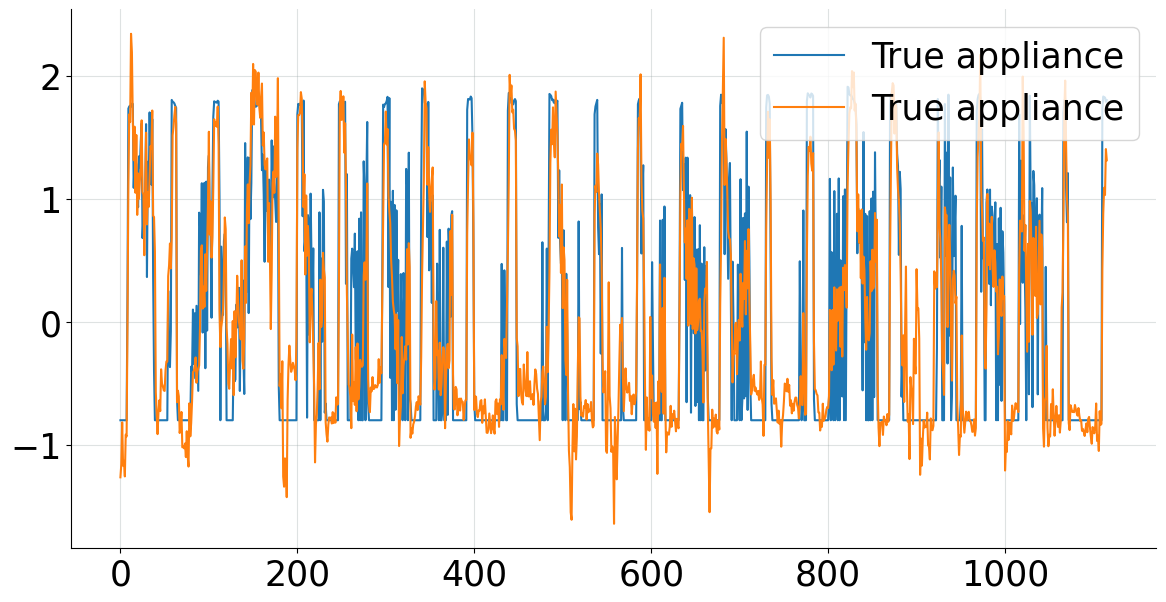

In [ ]:
plt.plot(y_train_sc[:,0], label='True appliance')
plt.plot(y_hat_lin[:,0], label = 'True appliance')
plt.legend()

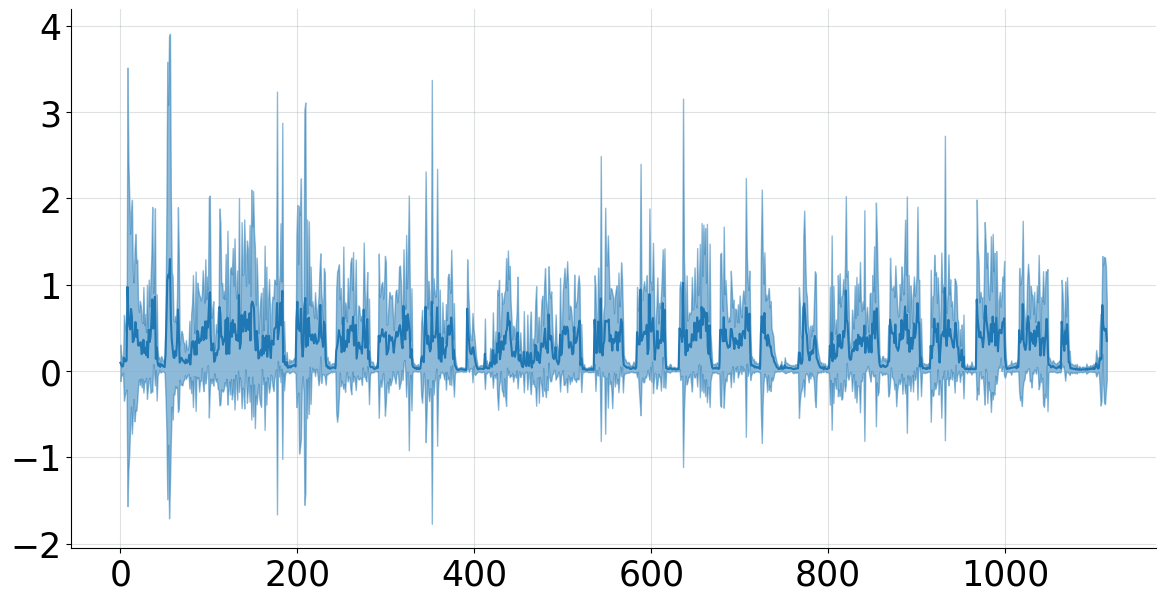

In [ ]:
mu = np.mean((y_hat_lin-y_train_sc)**2,axis = 1)
sigma = np.std((y_hat_lin-y_train_sc)**2,axis = 1)

fig, ax = plt.subplots()

x = np.linspace(0, 1115, 1116)
y = mu

ymin = mu - sigma
ymax = mu + sigma

ax.plot(x, y, color='C0')
plt.fill_between(x, ymin, ymax, color='C0', alpha=0.5);

In [ ]:
### TO DO
# Fit penalization parameter and analyze results on the test set
#from sklearn.linear_model import RidgeCV
#alps = [1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1, 2, 3, 4, 5]
#ridge_reg = RidgeCV(alphas=alps).fit(X_train_sc, y_train_sc)
#ridge_reg.alpha_

2.0

In [ ]:
#y_hat_ridge = ridge_reg.predict(X_train_sc)
#MAE = mean_absolute_error(y_hat_ridge,y_train_sc)
#MSE = mean_squared_error(y_hat_ridge,y_train_sc)
#print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.3897	 MSE: 0.2942


In [ ]:
#y_hat_ridge = ridge_reg.predict(X_test_sc)
#MAE = mean_absolute_error(y_hat_ridge,y_test_sc)
#MSE = mean_squared_error(y_hat_ridge,y_test_sc)
#print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.3946	 MSE: 0.3155


### Kernel regression baselines

A function $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ is said to be a positive semi-definite kernel if and only if it is symmetric and if for all $n\geqslant 1$, $(x_1,\ldots,x_n)\in(\mathbb{R}^d)^n$ and all $(a_1,\ldots,a_n)\in\mathbb{R}^n$,
$$
\sum_{1\leqslant i,j\leqslant n}a_ia_jk(x_i,x_j) \geqslant 0\,.
$$

The following functions, defined on $\mathbb{R}^d\times\mathbb{R}^d$, are positive semi-definite kernels:

$$
k:(x,y)\mapsto x^Ty \quad\mathrm{and}\quad k:(x,y)\mapsto \mathrm{exp}\left(-\|x-y\|^2/(2\sigma^2\right)\,,\; \sigma>0\,.
$$


Let $\mathcal{F}$ be a Hilbert space of functions $f:\mathbb{R}^d\to\mathbb{R}$. A symmetric function $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ is said to be a reproducing kernel of $\mathcal{F}$ if and only if:

1. for all $x\in\mathbb{R}^d$, $k(x,\cdot)\in\mathcal{F}$ ;

2. for all $x\in\mathbb{R}^d$ and all $f\in\mathcal{F}$, $\langle f; k(x,\cdot)\rangle_\mathcal{F} = f(x)$ .

The space $\mathcal{F}$ is said to be a reproducing kernel Hilbert space with kernel $k$.



Let $k:\mathbb{R}^d\times\mathbb{R}^d:\to \mathbb{R}$ be a positive definite kernel and $\mathcal{F}$ the RKHS with kernel $k$. Then,

$$
\widehat f^n_{\mathcal{F}} \in \underset{f\in\mathcal{F}}{\mathrm{min}}\;\frac{1}{n}\sum_{i=1}^n (Y_i - f(X_i))^2 + \lambda\|f\|_\mathcal{F}^2\,,
$$

where $\|f\|^2_\mathcal{F} = \langle f\,;\, f\rangle_\mathcal{F}$, is given by $\widehat f^n_{\mathcal{F}} : x \mapsto \sum_{i=1}^n \widehat \alpha_i k(X_i,x)$, where

$$
\widehat\alpha \in \underset{\alpha \in (\mathbb{R}^d)^n}{\mathrm{argmin}}\;\left\{\frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \sum_{1\leqslant i,j \leqslant n}\alpha_i \alpha_j k(X_i,X_j) = \frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \alpha^TK\alpha\right\}\,,
$$

where for all $1\leqslant i,j\leqslant n$, $K_{i,j} = k(X_i,X_j)$.

In practice, once the matrix $K$ is built, kernel ridge regression boils down to solving this optimization problem to obtain $\widehat \alpha$. Then, the estimated function $\widehat f^n_{\mathcal{F}}$ is a mixture of kernels evaluated at each data points with weights given by $\alpha$.

**Parameter estimation**

It is enough to follow the exact same steps as in the standard linear setting
$$
\nabla \left(\frac{1}{n}\|Y - K\alpha\|^2_2 + \lambda \alpha^TK\alpha\right) = \frac{2}{n}K^TK\alpha - \frac{2}{n}K^TY +  2\lambda K\alpha = 2\left\{\left(\frac{1}{n}K^TK + \lambda K\right)\alpha - \frac{1}{n}K^TY\right\}\,.
$$

Therefore, using that $K$ is symmetric,

$$
\widehat \alpha = \left(K^TK + \lambda n I_n\right)^{-1}Y\,.
$$

In [ ]:
# Train an elementary regression model
from sklearn.kernel_ridge import KernelRidge
krr = KernelRidge(alpha=1.0, kernel = 'polynomial')
krr.fit(X_train_sc, y_train_sc)

KernelRidge(alpha=1.0, kernel='polynomial')

In [ ]:
y_hat_ker = krr.predict(X_train_sc)
y_hat_ker.shape

(1116, 32)

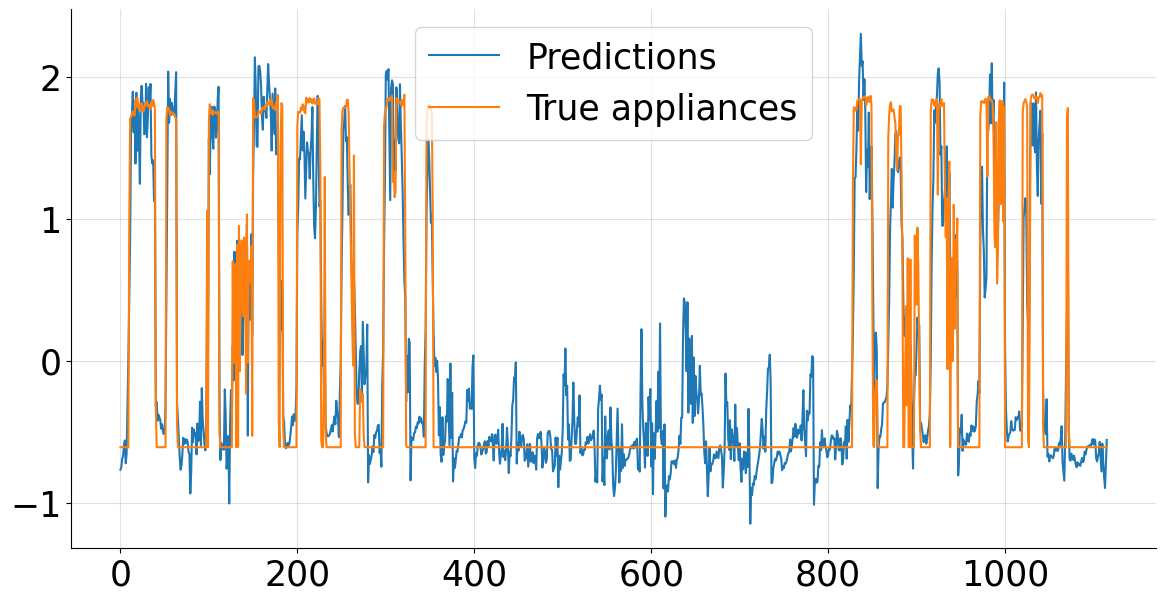

In [ ]:
plt.plot(y_hat_ker[:,9], label = 'Predictions')
plt.plot(y_train_sc[:,9], label = 'True appliances')
plt.legend();

In [ ]:
MAE = mean_absolute_error(y_hat_ker,y_train_sc)
MSE = mean_squared_error(y_hat_ker,y_train_sc)
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.2887	 MSE: 0.1859


In [ ]:
y_hat_ker = krr.predict(X_test_sc)
MAE = mean_absolute_error(y_hat_ker,y_test_sc)
MSE = mean_squared_error(y_hat_ker,y_test_sc)
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.3837	 MSE: 0.3280


In [ ]:
mu = np.mean((y_hat_ker-y_train_sc)**2,axis = 1)
sigma = np.std((y_hat_ker-y_train_sc)**2,axis = 1)

fig, ax = plt.subplots()

x = np.linspace(0, 1115, 1116)
y = mu

ymin = mu - sigma
ymax = mu + sigma

ax.plot(x, y, color='C0')
plt.fill_between(x, ymin, ymax, color='C0', alpha=0.5);

ValueError: operands could not be broadcast together with shapes (372,32) (1116,32) 

In [ ]:
### TO DO
# Fit penalization parameter and analyze results on the test set with other kernels (‘rbf’, ‘laplacian’, ‘sigmoid’, ‘cosine’)
#krr = KernelRidge(alpha=2.0, kernel = 'polynomial')
#krr.fit(X_train_sc, y_train_sc)
#y_hat_ker = krr.predict(X_test_sc)
#MAE = mean_absolute_error(y_hat_ker,y_test_sc)
#MSE = mean_squared_error(y_hat_ker,y_test_sc)
#print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.3845	 MSE: 0.3279


### Lasso regression

It is assumed that for all $1\leqslant i \leqslant n$,

$$
Y_i = X^\top_i \beta_{\star} + \varepsilon_i\,,
$$

where the $(\varepsilon_i)_{1\leqslant i\leqslant n}$ are i.i.d. random variables in $\mathbb{R}$, $X_i\in\mathbb{R}^d$ and $\beta_{\star}$ is an unknown vector in $\mathbb{R}^d$. Let $Y\in\mathbb{R}^n$ (resp. $\varepsilon\in\mathbb{R}^n$)  be the random vector such that  for all $1\leqslant i \leqslant n$, the $i$-th component of $Y$ (resp. $\varepsilon$) is $Y_i$ (resp. $\varepsilon_i$) and $X\in\mathbb{R}^{n\times d}$ the matrix with line $i$ equal to $X^\top_i$. The model is then written

$$
Y = X \beta_{\star} + \varepsilon\,.
$$

In this section, it is assumed that $\mathbb{E}[\varepsilon] = 0$ and $\mathbb{E}[\varepsilon \varepsilon^\top] = \sigma_{\star}^2 I_n$. The Lasso estimate of $\beta_{\star}$ is defined as a solution to

$$
\widehat \beta_n\in  \mathrm{argmin}_{\beta\in\mathbb{R}^d}\,\left( n^{-1}\|Y - X\beta\|_2^2 + \lambda \|\beta\|_1\right)\,,
$$

where $\lambda>0$.

A coordinate descent can be applied to solve the LASSO optimization problem. In this case, solving the Lasso optimization problem amounts to producing iterative estimators, where at each iteration, a coordinate is selected to be updated. Then, the objective function  is optimized explicitly  with respect to the selected coordinate. For all $\beta \in \mathbb{R}^d$,  
$$
\nabla_\beta \|Y - X\beta\|_2^2 = - 2 X^\top (Y-X\beta)\,.
$$
Then, for all $1\leqslant j \leqslant d$, $(\nabla_\beta \|Y - X\beta\|_2^2)_j = -2 {\bf X}^\top_j (Y-X\beta)$, where ${\bf X}_j$ is the $j$-th column of the matrix $X$.
Define, for all $1\leqslant j \leqslant d$,
$$
\upsilon_{j}={\bf X}^\top_{j}\left(Y-\sum_{\substack{i=1\\ i\neq j}}^d\beta_{i}{\bf X}_{i}\right)\,.
$$
Assuming that the columns of $X$ are normalized, i.e. for all $1\leqslant k \leqslant d$, ${\bf X}^\top_{k}{\bf X}_{k}=1$, yields
$$
(\nabla_\beta \|Y - X\beta\|_2^2)_j = -2( \upsilon_j - \beta_j)\,.
$$
Consequently, for all $\beta_j \neq 0$,
$$
(\nabla_\beta ( n^{-1}\|Y - X\beta\|_2^2 +  \lambda\|\beta\|_1))_j= \frac{2}{n}( \beta_j - \upsilon_j + \lambda n\textrm{sign}(\beta_j)/2)\,.
$$
For all $1\leqslant j\leqslant d$,  $\beta_j \mapsto  n^{-1}\|Y - X\beta\|_2^2 + \lambda\|\beta\|_1$ is convex and grows to infinity when $|\beta_j|\to \infty$ and admits thus a minimum at some $\beta_j^{\star}\in\mathbb{R}$.

- If $\beta_j^{\star} \neq 0$, then
$$
\beta_j^{\star} = \upsilon_j\left( 1 - \frac{\lambda n~\textrm{sign}(\beta_j^{\star})}{2 \upsilon_j}\right)\,,
$$
which yields, as  $\textrm{sign}(\beta_j^{\star}) = \textrm{sign}(\upsilon_j)$,
$$
\beta_j^{\star} = \upsilon_j\left(1 - \frac{\lambda n }{2 |\upsilon_j|}\right)
$$
and
$$
1 - \frac{\lambda n }{2 |\upsilon_j|} \geqslant 0\,.
$$
- If $1 - \lambda n/(2 |\upsilon_j|)<0$, there is no solution to $(\nabla_\beta ( n^{-1}\|Y - X\beta\|_2^2 +  \lambda\|\beta\|_1))_j=0$ for $\beta_j \neq 0$.  Since $\beta_j \mapsto  n^{-1}\|Y - X\beta\|_2^2 + \lambda\|\beta\|_1$ admits a minimum, $\beta_j^{\star}=0$.
Therefore,
$$
\beta_j^{\star} = \upsilon_j\left( 1 - \frac{\lambda n}{2 |\upsilon_j|}\right)_+ = \mathrm{max}\left(0;\upsilon_j\left( 1 - \frac{\lambda n}{2 |\upsilon_j|}\right)\right)\,.
$$

As a conlusion:
- if $|\upsilon_j|\geq \lambda n / 2$, $\beta_j^{\star} = \upsilon_j( 1 - \frac{\lambda n}{2 |\upsilon_j|})$ and if $|\upsilon_j|< \lambda n / 2$, $\beta_j^{\star} = 0$.

$$
\beta_j^{\star} = \begin{cases}
\upsilon_j + \frac{\lambda n}{2} & \text{if } \upsilon_j\leq -\lambda n / 2, \\
\upsilon_j - \frac{\lambda n}{2} & \text{if } \upsilon_j\geq \lambda n / 2, \\
0 & \text{otherwise}. \\
\end{cases}
$$

In [ ]:
from sklearn.linear_model import Lasso, Ridge

In [ ]:
n_alphas = 10
alphas = np.logspace(-3, 3, n_alphas)
### TO DO
# Analyze results as a function of the penalty parameter
#lasso = Lasso(max_iter=1000)
#coefs = []
#nb_zeros = []
#rmse = []
#for a in alphas:
#    lasso.set_params(alpha=a)
#    lasso.fit(X_train_sc, y_train_sc)
#    coefs.append(lasso.coef_)
#    nb_zeros.append(np.count_nonzero(lasso.coef_==0))
#    y_hat_lasso = lasso.predict(X_test_sc)
#    rmse.append(mean_squared_error(y_hat_lasso,y_test_sc))


#ridge = Ridge()
#coefs_ridge = []
#nb_zeros_ridge = []
#rmse_ridge = []
#for a in alphas:
#    ridge.set_params(alpha=a)
#    ridge.fit(X_train_sc, y_train_sc)
#    coefs_ridge.append(ridge.coef_)
#    nb_zeros_ridge.append(np.count_nonzero(ridge.coef_==0))
#    y_hat_ridge = ridge.predict(X_test_sc)
#    rmse_ridge.append(mean_squared_error(y_hat_ridge,y_test_sc))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.546e+01, tolerance: 1.116e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.942e+00, tolerance: 1.116e-01
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.815e+00, tolerance: 1.116e

In [ ]:
lasso.coef_.shape

(32, 47)

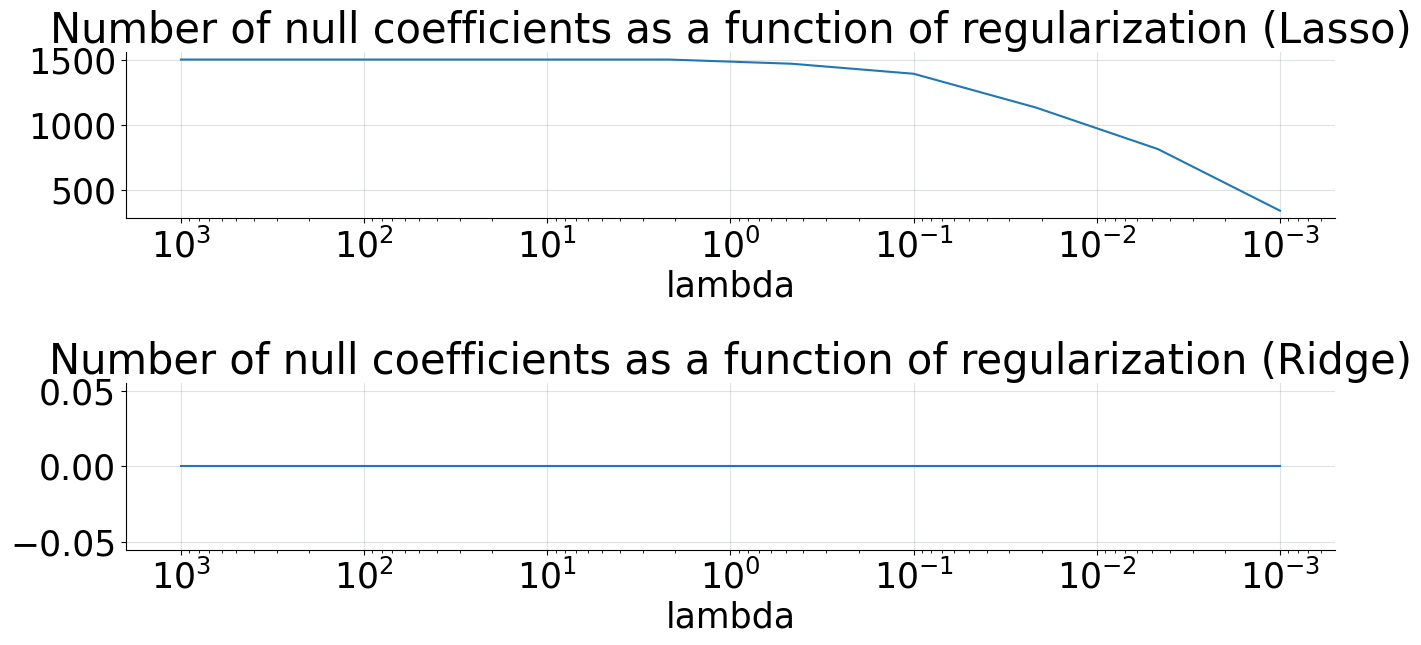

In [ ]:
### TO DO
# Display the number of zero coefficients as a function of the penalization parameter
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(alphas, nb_zeros)
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])
ax1.set_xlabel("lambda")
ax1.set_title("Number of null coefficients as a function of regularization (Lasso)")
ax1.axis("tight")

ax2.plot(alphas, nb_zeros_ridge)
ax2.set_xscale("log")
ax2.set_xlim(ax2.get_xlim()[::-1])
ax2.set_xlabel("lambda")
ax2.set_title("Number of null coefficients as a function of regularization (Ridge)")
ax2.axis("tight")

plt.tight_layout()
plt.show()

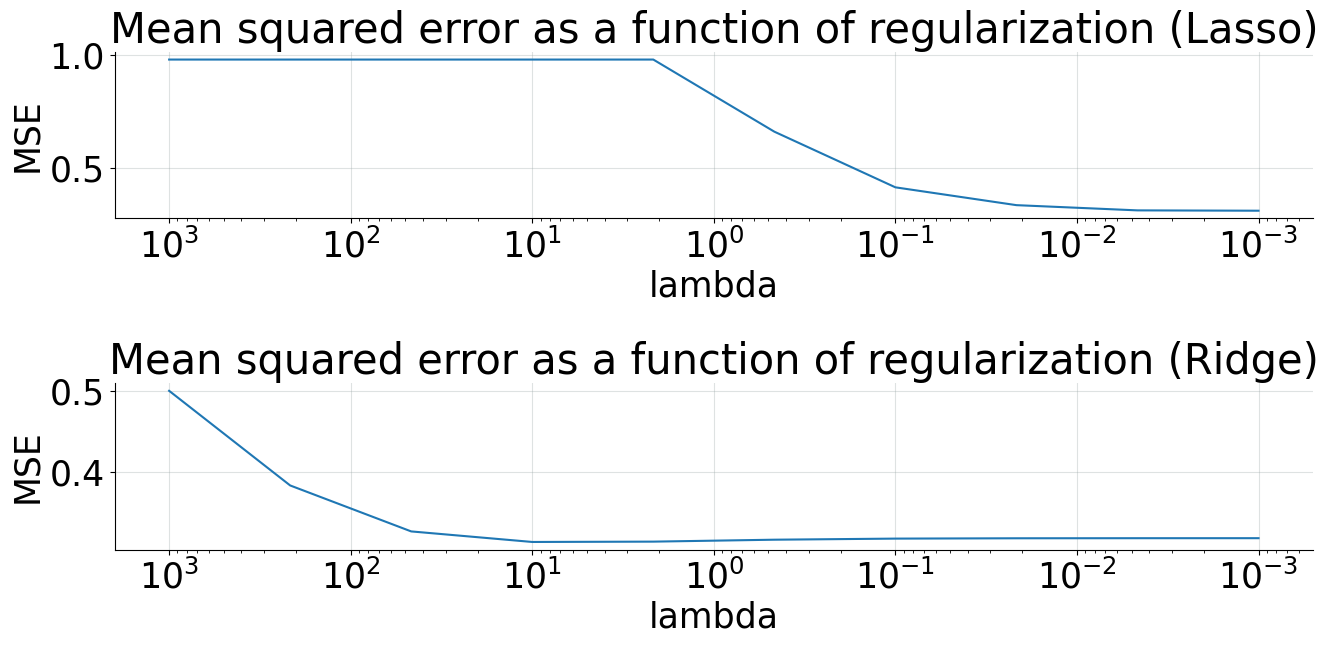

In [ ]:
### TO DO
# Display the MSE as a function of the penalization parameter
fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(alphas, rmse)
ax1.set_xscale("log")
ax1.set_xlim(ax1.get_xlim()[::-1])  # reverse axis
ax1.set_xlabel("lambda")
ax1.set_ylabel('MSE')
ax1.set_title("Mean squared error as a function of regularization (Lasso)")
ax1.axis("tight")

ax2.plot(alphas, rmse_ridge)
ax2.set_xscale("log")
ax2.set_xlim(ax2.get_xlim()[::-1])
ax2.set_xlabel("lambda")
ax2.set_ylabel('MSE')
ax2.set_title("Mean squared error as a function of regularization (Ridge)")
ax2.axis("tight")

plt.tight_layout()
plt.show()

### Deep learning approaches

In [ ]:
def get_model(model, model_params):
    models = {"rnn": RNNmodel,"lstm": LSTMmodel,"gru": GRUmodel}
    return models.get(model.lower())(**model_params)

In [ ]:
class Optimization:
    def __init__(self, model, loss_fn, optimizer):
        """
        model (RNNModel, LSTMModel, GRUModel): selected model
        loss_fn (torch.nn.modules.Loss): loss function
        optimizer (torch.optim.Optimizer): function to optimize loss
        """
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.train_losses = []
        self.val_losses = []

    def train_step(self, x, y):
        """
        x (torch.Tensor): input tensor
        y (torch.Tensor): target tensor
        """

        self.model.train()

        # Predictions
        yhat = self.model(x)

        # Loss
        loss = self.loss_fn(y, yhat)

        # Gradient for the optimization
        loss.backward()

        # Updates parameters
        self.optimizer.step()
        self.optimizer.zero_grad()

        # Returns the loss
        return loss.item()

    def train(self, train_loader, val_loader, batch_size=64, n_epochs=50, n_features=1):
        """
        train_loader (torch.utils.data.DataLoader): training data
        val_loader (torch.utils.data.DataLoader): validation data
        batch_size (int): batch size
        n_epochs (int): number of epochs
        n_features (int): number of features
        """
        for epoch in range(1, n_epochs + 1):
            batch_losses = []
            for x_batch, y_batch in train_loader:
                #print(x_batch.shape)
                #x_batch = x_batch.view([batch_size, -1, n_features]).to(device)
                x_batch = x_batch.to(device)
                #print(x_batch.shape)
                y_batch = y_batch.to(device)
                #print(y_batch.shape)
                loss = self.train_step(x_batch, y_batch)
                batch_losses.append(loss)
            training_loss = np.mean(batch_losses)
            self.train_losses.append(training_loss)

            with torch.no_grad():
                batch_val_losses = []
                for x_val, y_val in val_loader:
                    #x_val = x_val.view([batch_size, -1, n_features]).to(device)
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)
                    self.model.eval()
                    yhat = self.model(x_val)


                    val_loss = self.loss_fn(y_val, yhat).item()
                    batch_val_losses.append(val_loss)
                validation_loss = np.mean(batch_val_losses)
                self.val_losses.append(validation_loss)


                print(f"[{epoch}/{n_epochs}] Training loss: {training_loss:.4f}\t Validation loss: {validation_loss:.4f}")

    def evaluate(self, test_loader, batch_size=1, n_features=1):
        """
        test_loader (torch.utils.data.DataLoader): dataLoader
        batch_size (int): batch size
        n_features (int): number of features
        """
        with torch.no_grad():
            predictions = []
            values = []
            for x_test, y_test in test_loader:
                #x_test = x_test.view([batch_size, -1, n_features]).to(device)
                x_test = x_test.to(device)
                y_test = y_test.to(device)

                self.model.eval()
                yhat = self.model(x_test)

                yhat=yhat.cpu().data.numpy()
                predictions.append(yhat)
                y_test=y_test.cpu().data.numpy()
                values.append(y_test)

        return predictions, values

    def plot_losses(self):
        plt.style.use('ggplot')
        plt.figure(figsize=(8,8))
        plt.plot(self.train_losses, label="Training loss")
        plt.plot(self.val_losses, label="Validation loss")
        plt.legend()
        plt.show()
        plt.close()

In [ ]:
X_train.shape

(1116, 47)

In [ ]:
y_train.shape

(1116, 32)

#### Hyperparameters

In [ ]:
input_d = len(X_train.columns)
output_d = 32
hidden_d = 16
layer_n = 4
p_drop = 0.3
n_epochs = 50
lrate = 1e-4
weight_decay = 1e-6

In [ ]:
import torch.optim as optim
def Train_loop(model_name):
        model_params = {'input_d': input_d,
                        'hidden_d' : hidden_d,
                        'layer_n' : layer_n,
                        'output_d' : output_d,
                        'dropout_p' : p_drop}

        model = get_model(model_name, model_params)
        loss_fn = nn.MSELoss(reduction="mean")
        optimizer = optim.Adam(model.parameters(), lr=lrate, weight_decay=weight_decay)

        opt = Optimization(model=model.to(device), loss_fn=loss_fn, optimizer=optimizer)
        opt.train(train_loader, test_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_d)
        opt.plot_losses()

        predictions, values = opt.evaluate(
            test_loader_one,
            batch_size=1,
            n_features=input_d
        )
        return predictions,values


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

[1/50] Training loss: 0.2810	 Validation loss: 0.2524
[2/50] Training loss: 0.2308	 Validation loss: 0.2158
[3/50] Training loss: 0.2002	 Validation loss: 0.1899
[4/50] Training loss: 0.1793	 Validation loss: 0.1732
[5/50] Training loss: 0.1663	 Validation loss: 0.1631
[6/50] Training loss: 0.1588	 Validation loss: 0.1563
[7/50] Training loss: 0.1527	 Validation loss: 0.1483
[8/50] Training loss: 0.1439	 Validation loss: 0.1351
[9/50] Training loss: 0.1305	 Validation loss: 0.1264
[10/50] Training loss: 0.1227	 Validation loss: 0.1190
[11/50] Training loss: 0.1170	 Validation loss: 0.1127
[12/50] Training loss: 0.1128	 Validation loss: 0.1080
[13/50] Training loss: 0.1088	 Validation loss: 0.1035
[14/50] Training loss: 0.1055	 Validation loss: 0.1000
[15/50] Training loss: 0.1026	 Validation loss: 0.0969
[16/50] Training loss: 0.1000	 Validation loss: 0.0946
[17/50] Training loss: 0.0982	 Validation loss: 0.0918
[18/50] Training loss: 0.0962	 Validation loss: 0.0896
[19/50] Training lo

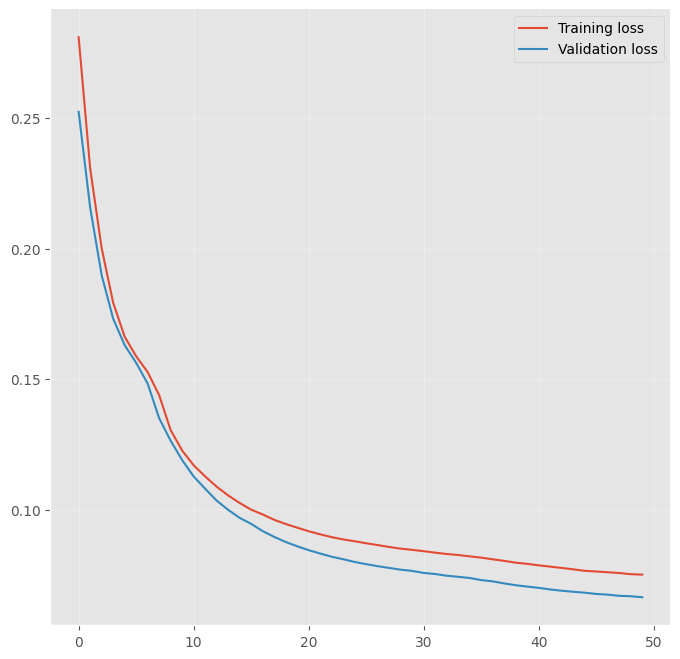

In [ ]:
mod = 'rnn'
predictions, values = Train_loop(mod)

In [ ]:
preds = np.squeeze(predictions)
vals = np.squeeze(values)
np.shape(vals)

(325, 48, 32)

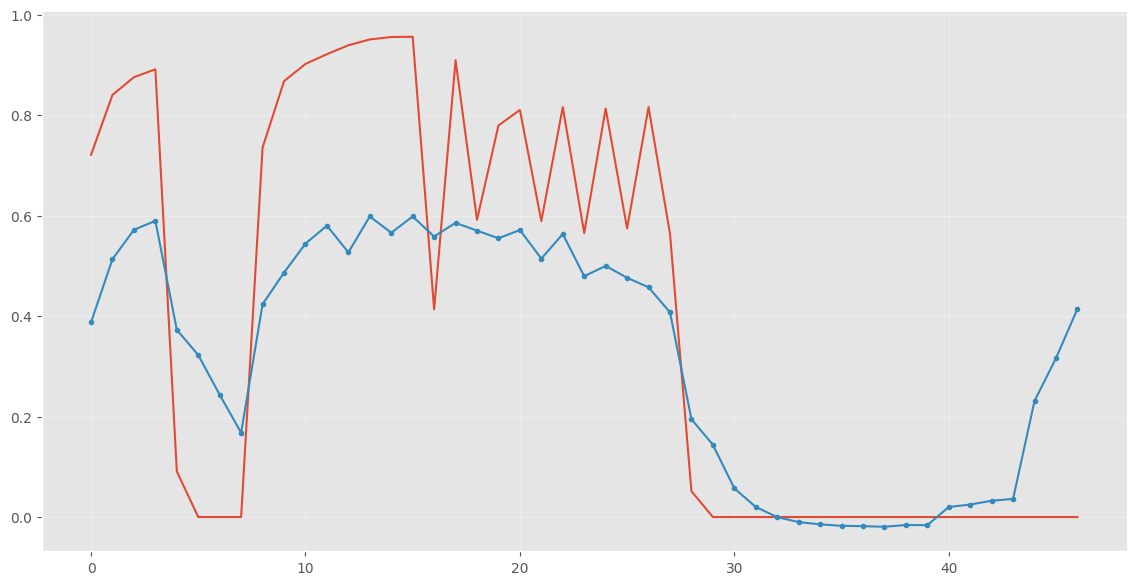

In [ ]:
plt.plot(vals[48,0:47,15]);
plt.plot(preds[48,0:47,15], '.-');

In [ ]:
MAE = mean_absolute_error(np.squeeze(values),np.squeeze(predictions))
MSE = mean_squared_error(np.squeeze(values),np.squeeze(predictions))
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

ValueError: Found array with dim 3. None expected <= 2.

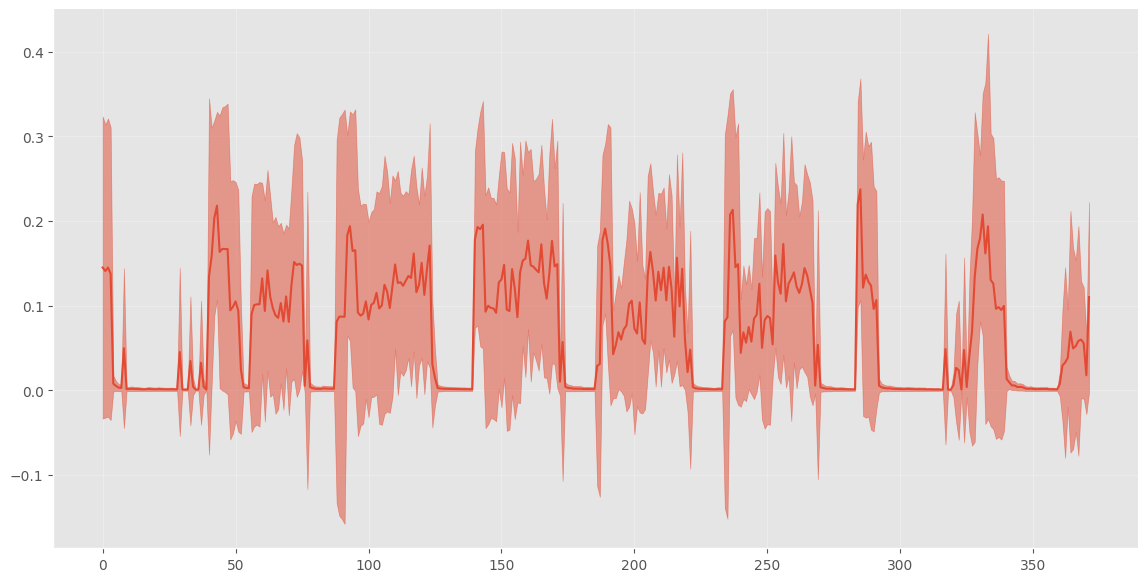

In [ ]:
mu = np.mean((np.squeeze(values)-np.squeeze(predictions))**2,axis = 1)
sigma = np.std((np.squeeze(values)-np.squeeze(predictions))**2,axis = 1)

fig, ax = plt.subplots()

x = np.linspace(0, 371, 372)
y = mu

ymin = mu - sigma
ymax = mu + sigma

ax.plot(x, y, color='C0')
plt.fill_between(x, ymin, ymax, color='C0', alpha=0.5);

In [ ]:
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()

In [ ]:
vals

array([9.62e-01, 9.93e-01, 9.92e-01, ..., 8.99e-05, 8.77e-01, 4.80e-01],
      dtype=float32)

In [ ]:
preds

array([0.68, 0.62, 0.62, ..., 0.23, 0.22, 0.28], dtype=float32)

In [ ]:
df_result = pd.DataFrame(data={"value": vals, "prediction": preds})

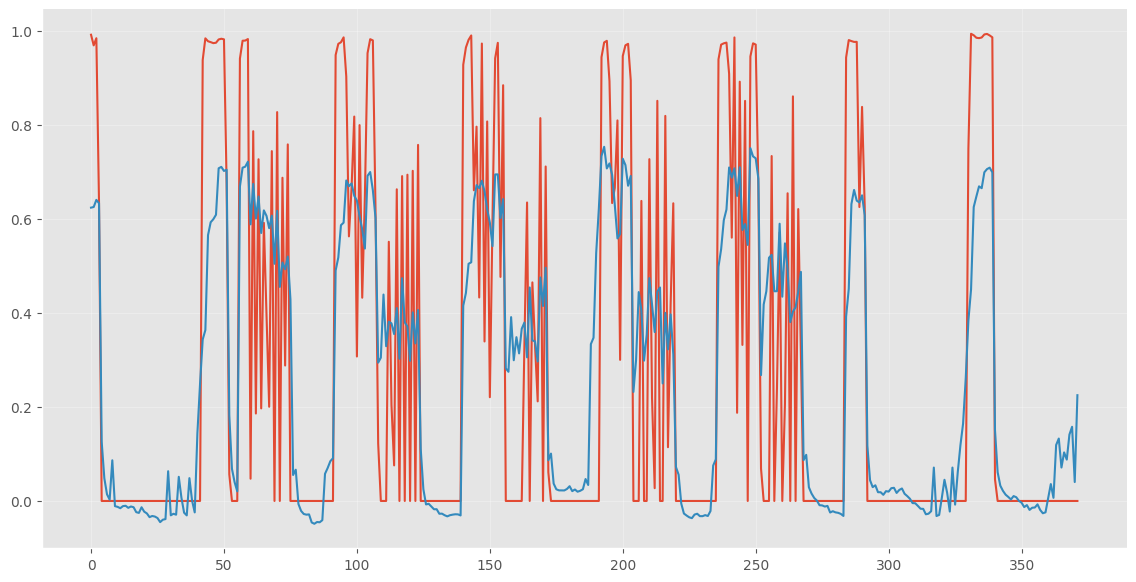

In [ ]:
res = np.squeeze(values)
pred = np.squeeze(predictions)
plt.plot(res[:,1])
plt.plot(pred[:,1])

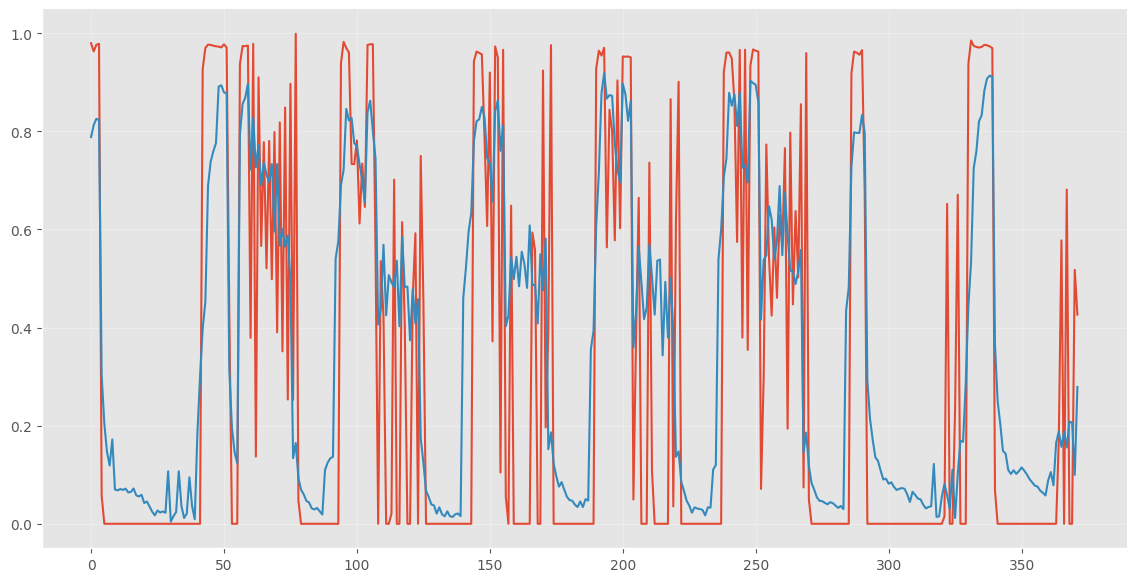

In [ ]:
res = np.squeeze(values)
pred = np.squeeze(predictions)
plt.plot(res[:,10])
plt.plot(pred[:,10])

[1/200] Training loss: 0.2963	 Validation loss: 0.2897
[2/200] Training loss: 0.2906	 Validation loss: 0.2840
[3/200] Training loss: 0.2848	 Validation loss: 0.2783
[4/200] Training loss: 0.2790	 Validation loss: 0.2723
[5/200] Training loss: 0.2729	 Validation loss: 0.2662
[6/200] Training loss: 0.2666	 Validation loss: 0.2597
[7/200] Training loss: 0.2600	 Validation loss: 0.2529
[8/200] Training loss: 0.2533	 Validation loss: 0.2458
[9/200] Training loss: 0.2462	 Validation loss: 0.2385
[10/200] Training loss: 0.2387	 Validation loss: 0.2309
[11/200] Training loss: 0.2314	 Validation loss: 0.2233
[12/200] Training loss: 0.2239	 Validation loss: 0.2156
[13/200] Training loss: 0.2164	 Validation loss: 0.2081
[14/200] Training loss: 0.2094	 Validation loss: 0.2010
[15/200] Training loss: 0.2019	 Validation loss: 0.1943
[16/200] Training loss: 0.1962	 Validation loss: 0.1884
[17/200] Training loss: 0.1910	 Validation loss: 0.1830
[18/200] Training loss: 0.1849	 Validation loss: 0.1784
[

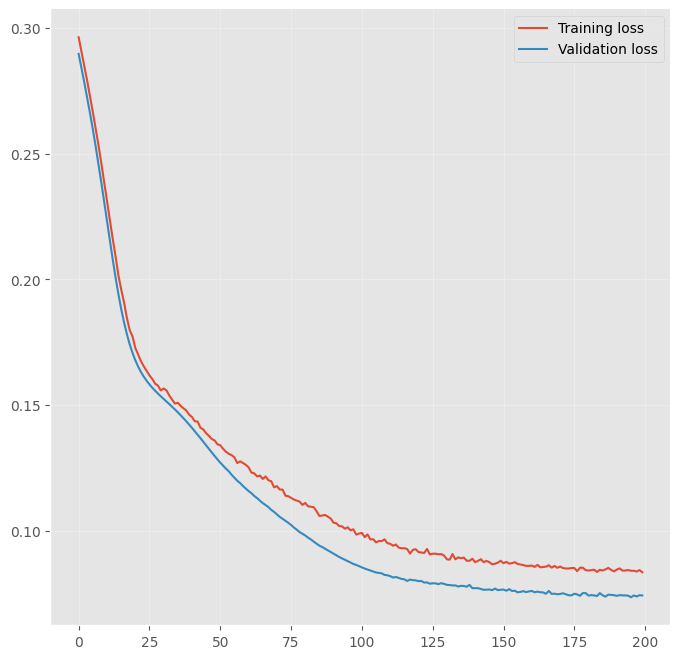

In [ ]:
mod = 'gru'
predictions, values = Train_loop(mod)

In [ ]:
MAE = mean_absolute_error(np.squeeze(values),np.squeeze(predictions))
MSE = mean_squared_error(np.squeeze(values),np.squeeze(predictions))
print(f"[MAE: {MAE:.4f}\t MSE: {MSE:.4f}")

[MAE: 0.1892	 MSE: 0.0735


In [ ]:
vals = np.concatenate(values, axis=0).ravel()
preds = np.concatenate(predictions, axis=0).ravel()
df_result = pd.DataFrame(data={"value": vals, "prediction": preds})

## <font color=darkred> Auto Encoders</font>

Consider random variables $(Z,X)$ in $\mathbb{R}^d\times \mathbb{R}^m$ where $X$ is the observation and $Z$ is not observed. Assume that the distribution of $(Z,X)$ has a density $(z,x)\mapsto p_\theta(z,x)$ with respect to the Lebesgue measure. In this framework, we write
$$
(z,x)\mapsto p_\theta(z,x) = p_\theta(z)p_\theta(x|z)\,,
$$
where $z\mapsto p_\theta(z)$ is a prior density for $Z$ and $x \mapsto p_\theta(x|z)$ is the likelihood of $X$ given $Z$. We **do not** have access to the conditional distribution of $Z$ given $X$ in general as:
$$
z\mapsto p_\theta(z|x) = \frac{p_\theta(z)p_\theta(x|z)}{p_\theta(x)}\,,
$$
where $p_\theta(x) = \int p_\theta(z)p_\theta(x|z) \mathrm{d} z$ is an intractable integral.

**Example 1**.
Deep latent variable model for multivariate Benoulli data. In this setting, $X\in\{0,1\}^D$ and conditionally on a variable $Z\in\mathbb{R}^d$, $(X_1,\ldots,X_D)$ are independent with Bernoulli distribution with parameters ${\bf p}_\theta(Z) = (p_{1,\theta}(Z),\ldots, p_{D,\theta}(Z))$, where ${\bf p}_\theta(Z) $ is the output of a Multi-layer Perceptron with input $Z$ and parameters $\theta$ (weights and biases). In this example, the input variable has a prior distribution $Z\sim \mathcal{N}(0,I_d)$ and, for any value of $\theta$, the conditional distribution of $Z$ given $X$ is not available explicitly.

In varitional inference, we introduce a family of possible candidate distributions to approximate $z\mapsto p_\theta(z|x)$. Consider $\mathcal{D} = \{q_\phi\}_{\phi\in\Phi}$ where $\Phi$ is a parameter space and where  $q_\phi$ are chosen so that:

  - for all $\phi$, $q_\phi$ is easy to evaluate ;
  - for all $\phi$, $q_\phi$ is easy to sample.


The distribution $p_\theta(x|z)$ is referred to as the **decoder**. This is the distribution used to **reconstruct data from encoded vectors**.

The distribution $q_\varphi(z|x)$ is referred to as the **encoder**. This is the distribution used to **encode complex data in a simple latent space**.

*Illustration from [1]*.

![](https://d3i71xaburhd42.cloudfront.net/329b84a919bfd1771be5bd14fa81e7b3f74cc961/22-Figure2.1-1.png)

*Another classical illustration of a generic VAE*

![Autoencoder](https://lilianweng.github.io/lil-log/assets/images/autoencoder-architecture.png)

### <font color=darkred>ELBO and loss function</font>


For all $x$ and all $\phi$,
\begin{align*}
\mathrm{KL}\left(q_\phi(\cdot|x)\|p_\theta(\cdot|x)\right) = \int q_\phi(z|x) \log \frac{q_\phi(z|x)}{p_\theta(z|x)} \mathrm{d}z&= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z|x)]\,,\\
 &= \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]+\log p_\theta(x)\,,\\
&= -\mathcal{L}(\theta,\phi,x)+\log p_\theta(x)\,,
\end{align*}
where $\mathcal{L}(\theta,\phi,x) = \mathbb{E}_{q_\phi}[\log q_\phi(Z|x)] - \mathbb{E}_{q_\phi}[\log p_\theta(Z,x)]$. Using Jensen's inequality, note that $\mathrm{KL}\left(q_\phi\|p_\theta(\cdot|x)\right) \geq 0$ so that
$$
\mathcal{L}(\theta,\phi,x)\leq \log p_\theta(x)\,.
$$
This motivates the name Evidence Lower Bound  (ELBO) of the surrogate quantity to be optimized. In variational inference,   $p_\theta(\cdot|x)$ is estimated by  $q_{\phi_*}$ where :
$$
(\theta_*\phi_*) \in \mathrm{argmax}_{\phi\in\Phi}\;\frac{1}{n}\sum_{i=1}^n\mathcal{L}(\theta,\phi,x_i)\,,
$$
with $(x_i)_{1\leq i \leq n}$ i.i.d. data from the dataset. In practice, $\mathcal{L}(\theta,\phi,x_i)$ cannot be computed and is replaced by a Monte Carlo estimate, i.e. we sample $Z_i\sim q_\phi(\cdot|x)$ and we compute:
$$
\widehat{\mathcal{L}}(\theta,\phi,x_i) = \log q_\phi(Z_i|x_i) - \log p_\theta(Z_i,x_i)\,.
$$

### <font color=darkred> Summary</font>

<font color=darkblue>**In standard settings**</font>:
- Data set made of instances $(X_i)$, $1\leq i \leq n$.
- Each $X_i$ can be arbitrarily complex (in our case a multidimensional time series).
- We associate with each $X_i$ latent representations sampled with distribution $q_\varphi(z|X_i)$.

<font color=darkblue>**After training**</font> we can:
- Understand the latent representations $Z\sim q_\varphi(\cdot|X_i)$ to cluster data.
- For each $X_i$, sample $Z_i\sim q_\varphi(\cdot|X_i)$ and then $X\sim p_\theta(X|Z_i)$ to understand how well data are reconstructed.
- Sample new data by sampling $Z\sim p_\theta$ and $X\sim p_\theta(X|Z)$.

<font color=darkblue>**NILM Setting - several remarks**</font>
- Each $X_i$ is a multivariate time series of detailed consumptions $X_i = X_{t_1:t_2,i}$.
- We have acces to additional data $C_{t_1:t_2,i}$ (global consumptions, weather, profiles) and context features.

So we need to build sequences of latent data $Z_{t_1:t_2,i}$ in order to (at least) predict sharply detailed consumptions:
- Prior model $p_\theta(Z|C)$ and decoder $p_\theta(X|Z,C)$.
- Encoder $q_\varphi(Z|X,C)$.

In [ ]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(Encoder, self).__init__()

    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim

    self.rnn1 = nn.LSTM(
      input_size=n_features,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )

    ## TO DO:
    ## Add a LSTM cell with output dimension given by embedding_dim
    self.rnn2 = nn.LSTM(
    input_size=self.hidden_dim,
    hidden_size=embedding_dim,
    num_layers=1,
    batch_first=True
    )

  def forward(self, x):
    x = x.reshape((1, self.seq_len, self.n_features))

    x, (_, _) = self.rnn1(x)
    x, (hidden_n, _) = self.rnn2(x)

    return hidden_n.reshape((self.n_features, self.embedding_dim))

#### Decoder

Similarly, a LSTM is used to build the decoder and predict recursively $x_{1:t}$ given $z_{1:t}$.

In [ ]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1):
    super(Decoder, self).__init__()

    self.seq_len, self.input_dim = seq_len, input_dim
    self.hidden_dim, self.n_features = 2 * input_dim, n_features

    self.rnn1 = nn.LSTM(
      input_size=input_dim,
      hidden_size=input_dim,
      num_layers=1,
      batch_first=True
    )

    ## TO DO:
    ## Add a LSTM cell with output dimension given by hidden_dim
    self.rnn2 = nn.LSTM(
    input_size=input_dim,
    hidden_size=self.hidden_dim,
    num_layers=1,
    batch_first=True
    )

    ## TODO: Add a linear cell to output the observation of dimension n_feature
    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    x = x.repeat(self.seq_len, self.n_features)
    x = x.reshape((self.n_features, self.seq_len, self.input_dim))

    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.reshape((self.seq_len, self.hidden_dim))

    return self.output_layer(x)

In [ ]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

#### Training

In [ ]:
def create_dataset(df):
  sequences = df.astype(np.float32).to_numpy().tolist()
  dataset = [torch.tensor(s).unsqueeze(1).float() for s in sequences]
  n_seq, seq_len, n_features = torch.stack(dataset).shape
  return dataset, seq_len, n_features

In [ ]:
train_dataset, seq_len, n_features = create_dataset(train_dataset)

AttributeError: 'TSDataset' object has no attribute 'astype'

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
import copy
train_dataset

In [ ]:
model = RecurrentAutoencoder(seq_len, n_features, 128)
model = model.to(device)

In [ ]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0

  for epoch in range(1, n_epochs + 1):
    model = model.train()

    train_losses = []

    for x_batch, y_batch in train_dataset:
        optimizer.zero_grad()
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        seq_pred = model(x_batch)
        loss = criterion(seq_pred, y_batch)
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
          #      loss = self.train_step(x_batch, y_batch)
          #      batch_losses.append(loss)
          #  training_loss = np.mean(batch_losses)
          #  self.train_losses.append(training_loss)

    #for seq_true in train_dataset:
    #  optimizer.zero_grad()
    #
#
 #     seq_true = seq_true.to(device)
  #    seq_pred = model(seq_true)

   #   loss = criterion(seq_pred, seq_true)

    #  loss.backward()
     # optimizer.step()

      #train_losses.append(loss.item())

    val_losses = []
    model = model.eval()
    with torch.no_grad():
      #for seq_true in val_dataset:
      for x_batch, y_batch in val_dataset:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        seq_pred = model(x_batch)

        #seq_true = seq_true.to(device)
        #seq_pred = model(seq_true)

        loss = criterion(seq_pred, y_batch)
        val_losses.append(loss.item())

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

In [ ]:
model, history = train_model(model,train_loader,test_loader,n_epochs=5)

RuntimeError: shape '[1, 48, 47]' is invalid for input of size 27072

In [ ]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)
  with torch.no_grad():
    model = model.eval()
    for seq_true in dataset:
      seq_true = seq_true.to(device)
      seq_pred = model(seq_true)

      loss = criterion(seq_pred, seq_true)

      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

## <font color=darkred> Variational Auto Encoders</font>

In [ ]:
# Encoder
class Encoder(nn.Module):
    def __init__(self, seq_len, feat_dim, embed_dim=32):
        super(Encoder, self).__init__()
        self.seq_len = seq_len
        self.feat_dim = feat_dim
        self.embed_dim = embed_dim
        self.hidden_dim = 2 * embed_dim

        self.rnn1 = nn.RNN(
            input_size=feat_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.RNN(
            input_size=self.hidden_dim,
            hidden_size=embed_dim,
            num_layers=1,
            batch_first=True
        )

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size from the input tensor
        x, _ = self.rnn1(x)
        x, hidden_n = self.rnn2(x)
        hidden_n = hidden_n.view(batch_size, self.embed_dim)
        return hidden_n

In [ ]:
# Decoder
class Decoder(nn.Module):
    def __init__(self, seq_len, feat_dim, input_dim, embed_dim):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.embed_dim = embed_dim
        self.hidden_dim = 2 * embed_dim
        self.feat_dim = feat_dim

        self.fc = nn.Linear(input_dim, embed_dim)
        self.rnn1 = nn.RNN(
            input_size=embed_dim,
            hidden_size=embed_dim,
            num_layers=1,
            batch_first=True
        )
        self.rnn2 = nn.RNN(
            input_size=embed_dim,
            hidden_size=self.hidden_dim,
            num_layers=1,
            batch_first=True
        )
        self.output_layer_mean = nn.Linear(self.hidden_dim, feat_dim)
        self.output_layer_log_var = nn.Linear(self.hidden_dim, feat_dim)  # New linear layer for log_var

    def forward(self, x):
        batch_size = x.size(0)

        x = self.fc(x)
        x = x.unsqueeze(1).repeat(1, self.seq_len, 1)
        x, _ = self.rnn1(x)

        x, _ = self.rnn2(x)
        x = x.reshape(batch_size * self.seq_len, self.hidden_dim)

        # Separate linear layers for mean and log_var predictions
        x_mean = self.output_layer_mean(x)
        x_mean = x_mean.reshape(batch_size, self.seq_len, self.feat_dim)

        x_log_scale = self.output_layer_log_var(x)
        x_log_scale = x_log_scale.reshape(batch_size, self.seq_len, self.feat_dim)

        return x_mean, x_log_scale  # Return both mean and log_var

In [ ]:
# VAE
class VAE(nn.Module):
    def __init__(self, seq_len, feat_dim, enc_out_dim, latent_dim, beta, learning_rate, min_std):
        super().__init__()

        self.save_hyperparameters()

        # encoder, decoder
        self.beta = beta
        self.min_std = min_std
        self.encoder = Encoder(seq_len, feat_dim, enc_out_dim)
        self.decoder = Decoder(seq_len, feat_dim, latent_dim, enc_out_dim)

        # distribution parameters
        self.fc_mu = nn.Linear(enc_out_dim, latent_dim)
        self.fc_var = nn.Linear(enc_out_dim, latent_dim)

        # for the gaussian likelihood
        # self.log_scale = nn.Parameter(torch.Tensor([0.0]))

        self.learning_rate = learning_rate

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    def gaussian_likelihood(self, mean, logscale, sample):
        scale = torch.exp(logscale) + self.min_std
        dist = torch.distributions.Normal(mean, scale)
        log_pxz = dist.log_prob(sample)
        return log_pxz.sum(dim=(1, 2))

    def kl_divergence(self, z, mu, std):
        # --------------------------
        # Monte carlo KL divergence
        # --------------------------
        # 1. define the first two probabilities (in this case Normal for both)
        p = torch.distributions.Normal(torch.zeros_like(mu), torch.ones_like(std))
        q = torch.distributions.Normal(mu, std)

        # 2. get the probabilities from the equation
        log_qzx = q.log_prob(z)
        log_pz = p.log_prob(z)

        # kl
        kl = (log_qzx - log_pz)
        kl = kl.sum(-1)
        return kl

    def training_step(self, batch, batch_idx):
        x, _ = batch

        # encode x to get the mu and variance parameters
        x_encoded = self.encoder(x)
        mu, log_var = self.fc_mu(x_encoded), self.fc_var(x_encoded)

        # sample z from q
        std = torch.exp(log_var / 2)
        q = torch.distributions.Normal(mu, std)
        z = q.rsample().flatten(1)

        # decoded
        x_hat, x_log_scale = vae.decoder(z)

        # reconstruction loss
        recon_loss = self.gaussian_likelihood(x_hat, x_log_scale, x)

        # kl
        kl = self.kl_divergence(z, mu, std)

        # elbo
        elbo = (kl - (self.beta * recon_loss))
        elbo = elbo.mean()

        self.log_dict({
            'elbo': elbo,
            'kl': kl.mean(),
            'recon_loss': recon_loss.mean(),
            'reconstruction': recon_loss.mean(),
            'kl': kl.mean(),
        })

        return elbo

    def on_train_epoch_end(self):
        if self.current_epoch % 5 == 0:
            elbo = self.trainer.logged_metrics['elbo']
            kl = self.trainer.logged_metrics['kl']
            recon_loss = self.trainer.logged_metrics['recon_loss']
            print(f"\rEpoch {self.current_epoch + 1}: \tELBO: {elbo:.4f}, (KL: {kl:.4f}, Recon Loss: {recon_loss:.4f})")

    def save_model(self, checkpoint_path):
        torch.save(self.state_dict(), checkpoint_path)

    def load_model(self, checkpoint_path):
        self.load_state_dict(torch.load(checkpoint_path))

## <font color=darkred> Variational Auto Encoders (II)</font>

### Model

In [146]:
import numpy as np
import torch
from torch import nn, optim
from torch import distributions
from torch.utils.data import DataLoader
from torch.autograd import Variable
import os


In [147]:
from sklearn.base import BaseEstimator as SklearnBaseEstimator
class BaseEstimator(SklearnBaseEstimator):
    def summarize(self):
        return 'NotImplemented'

We first build an encoder which outputs the last hidden state $h_t$ from the input sequence using **recurrent architectures (LSTM, GRU, RNN)**.

In [145]:
class Encoder(nn.Module):
    def __init__(self, n_features, hidden_size, hidden_layer_depth, latent_length, dropout):

        super(Encoder, self).__init__()

        self.n_features = n_features
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length

        ### TO DO
        # Build a recurrent encoder model based on RNN, LSTM or GRU cells
        self.model = nn.LSTM(self.n_features, self.hidden_size, self.hidden_layer_depth, dropout = dropout)

    def forward(self, x):
        _, (h_end, c_end) = self.model(x)

        h_end = h_end[-1, :, :]
        return h_end

Build a regression function which outputs $z_t$ from the last hidden state $h_t$ **using linear transformations**.

In [148]:
class Lambda(nn.Module):
    def __init__(self, hidden_size, latent_length):
        super(Lambda, self).__init__()

        self.hidden_size = hidden_size
        self.latent_length = latent_length


        self.hidden_to_mean = nn.Linear(self.hidden_size, self.latent_length)
        self.hidden_to_logvar = nn.Linear(self.hidden_size, self.latent_length)

        nn.init.xavier_uniform_(self.hidden_to_mean.weight)
        nn.init.xavier_uniform_(self.hidden_to_logvar.weight)

    def forward(self, cell_output):

        self.latent_mean = self.hidden_to_mean(cell_output)
        self.latent_logvar = self.hidden_to_logvar(cell_output)

        if self.training:
            std = torch.exp(0.5 * self.latent_logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(self.latent_mean)
        else:
            return self.latent_mean

Build a decoder which **decodes the input sequence or predict the output sequence from $z_t$ using recurrent architectures**.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, sequence_length, batch_size, hidden_size, hidden_layer_depth, latent_length, output_size, dtype):

        super(Decoder, self).__init__()

        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.sequence_length = sequence_length
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length
        self.output_size = output_size
        self.dtype = dtype

        ### TO DO
        # Build a recurrent decoder model based on RNN, LSTM or GRU cells
        self.model = nn.LSTM(1, self.hidden_size, self.hidden_layer_depth)
        # self.model = nn.GRU(1, self.hidden_size, self.hidden_layer_depth)

        ### TO DO
        # Build a linear model to output a prediction based on the latent vector
        self.latent_to_hidden = nn.Linear(self.latent_length, self.hidden_size)
        self.hidden_to_output = nn.Linear(self.hidden_size, self.output_size)

        self.decoder_inputs = torch.zeros(self.sequence_length, self.batch_size, 1, requires_grad=True).type(self.dtype)
        self.c_0 = torch.zeros(self.hidden_layer_depth, self.batch_size, self.hidden_size, requires_grad=True).type(self.dtype)

        nn.init.xavier_uniform_(self.latent_to_hidden.weight)
        nn.init.xavier_uniform_(self.hidden_to_output.weight)

    def forward(self, latent):
        h_state = self.latent_to_hidden(latent)


        h_0 = torch.stack([h_state for _ in range(self.hidden_layer_depth)])
        decoder_output, _ = self.model(self.decoder_inputs, (h_0, self.c_0))

        out = self.hidden_to_output(decoder_output)
        return out

def _assert_no_grad(tensor):
    assert not tensor.requires_grad, \
        "nn criterions don't compute the gradient w.r.t. targets - please " \
        "mark these tensors as not requiring gradients"


In [163]:
class VRAE(BaseEstimator, nn.Module):

    def __init__(self, sequence_length, n_features, hidden_size=16, hidden_layer_depth=2, latent_length=20,
                 batch_size=16, learning_rate=0.005,
                 n_epochs=5, dropout_rate=0.,
                 cuda=False, clip=True, max_grad_norm=5):

        super(VRAE, self).__init__()


        self.dtype = torch.FloatTensor
        self.use_cuda = cuda

        if not torch.cuda.is_available() and self.use_cuda:
            self.use_cuda = False


        if self.use_cuda:
            self.dtype = torch.cuda.FloatTensor


        self.encoder = Encoder(n_features = n_features,
                               hidden_size=hidden_size,
                               hidden_layer_depth=hidden_layer_depth,
                               latent_length=latent_length,
                               dropout=dropout_rate)

        self.lmbd = Lambda(hidden_size=hidden_size,
                           latent_length=latent_length)

        self.decoder = Decoder(sequence_length=sequence_length,
                               batch_size = batch_size,
                               hidden_size=hidden_size,
                               hidden_layer_depth=hidden_layer_depth,
                               latent_length=latent_length,
                               output_size=n_features,
                               dtype=self.dtype)

        self.sequence_length = sequence_length
        self.hidden_size = hidden_size
        self.hidden_layer_depth = hidden_layer_depth
        self.latent_length = latent_length
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.n_epochs = n_epochs

        self.clip = clip
        self.max_grad_norm = max_grad_norm
        self.is_fitted = True

        if self.use_cuda:
            self.cuda()

        #TO DO: choose the optimizer (Adam, Adagrad, SGD, etc.)
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)


        #TO DO: choose the loss function (MSE, L1, etc.)
        self.loss_fn = nn.MSELoss(reduction='mean')

    def __repr__(self):
        return """VRAE(n_epochs={n_epochs},batch_size={batch_size},cuda={cuda})""".format(
                n_epochs=self.n_epochs,
                batch_size=self.batch_size,
                cuda=self.use_cuda)

    def forward(self, x):
        cell_output = self.encoder(x)
        latent = self.lmbd(cell_output)
        x_decoded = self.decoder(latent)

        return x_decoded, latent

    def _rec(self, x_decoded, x, loss_fn):

        latent_mean, latent_logvar = self.lmbd.latent_mean, self.lmbd.latent_logvar

        kl_loss = -0.5 * torch.mean(1 + latent_logvar - latent_mean.pow(2) - latent_logvar.exp())
        recon_loss = loss_fn(x_decoded, x)

        return kl_loss + recon_loss, recon_loss, kl_loss

    def compute_loss(self, X):

        x = Variable(X[:,:,:].type(self.dtype), requires_grad = True)

        x_decoded, _ = self(x)
        loss, recon_loss, kl_loss = self._rec(x_decoded, x.detach(), self.loss_fn)

        return loss, recon_loss, kl_loss, x


    def _train(self, train_loader):

        self.train()

        epoch_loss = 0
        t = 0

        for t, X in enumerate(train_loader):

            # Index first element of array to return tensor
            X = X[0]

            # required to swap axes, since dataloader gives output in (batch_size x seq_len x num_of_features)
            X = X.permute(1,0,2)

            self.optimizer.zero_grad()
            loss, recon_loss, kl_loss, _ = self.compute_loss(X)
            loss.backward()

            if self.clip:
                torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm = self.max_grad_norm)

            # accumulator
            epoch_loss += loss.item()

            self.optimizer.step()

        print('Average loss since 1st epoch: {:.4f}'.format(epoch_loss / t))


    def fit(self, dataset):

        train_loader = DataLoader(dataset = dataset,
                                  batch_size = self.batch_size,
                                  shuffle = True,
                                  drop_last=True)

        for i in range(self.n_epochs):
            print('Epoch: %s' % i)

            self._train(train_loader)

        self.is_fitted = True


    def _batch_transform(self, x):
        """
        Passes the given input tensor into encoder and lambda function

        :param x: input batch tensor
        :return: intermediate latent vector
        """
        return self.lmbd(
                    self.encoder(
                        Variable(x.type(self.dtype), requires_grad = False)
                    )
        ).cpu().data.numpy()

    def _batch_reconstruct(self, x):

        x = Variable(x.type(self.dtype), requires_grad = False)
        x_decoded, _ = self(x)

        return x_decoded.cpu().data.numpy()

    def reconstruct(self, dataset):
        """
        Given input dataset, creates dataloader, runs dataloader on `_batch_reconstruct`
        Prerequisite is that model has to be fit

        :param dataset: input dataset who's output vectors are to be obtained
        :param bool save: If true, dumps the output vector dataframe as a pickle file
        :return:
        """

        self.eval()

        test_loader = DataLoader(dataset = dataset,
                                 batch_size = self.batch_size,
                                 shuffle = False,
                                 drop_last=True) # Don't shuffle for test_loader

        if self.is_fitted:
            with torch.no_grad():
                x_decoded = []

                for t, x in enumerate(test_loader):
                    x = x[0]
                    x = x.permute(1, 0, 2)

                    x_decoded_each = self._batch_reconstruct(x)
                    x_decoded.append(x_decoded_each)

                x_decoded = np.concatenate(x_decoded, axis=1)
                return x_decoded


    def transform(self, dataset):
        """
        Given input dataset, creates dataloader, runs dataloader on `_batch_transform`
        Prerequisite is that model has to be fit

        :param dataset: input dataset who's latent vectors are to be obtained
        :param bool save: If true, dumps the latent vector dataframe as a pickle file
        :return:
        """
        self.eval()

        test_loader = DataLoader(dataset = dataset,
                                 batch_size = self.batch_size,
                                 shuffle = False,
                                 drop_last=True)

        with torch.no_grad():
            z = []

            for t, x in enumerate(test_loader):
                x = x[0]
                x = x.permute(1, 0, 2)

                z_t = self._batch_transform(x)
                z.append(z_t)

            #z_run = np.concatenate(z_run, axis=0)
            return z

    def fit_transform(self, dataset):
        """
        Combines the `fit` and `transform` functions above

        :param dataset: Dataset on which fit and transform have to be performed
        :param bool save: If true, dumps the model and latent vectors as pickle file
        :return: latent vectors for input dataset
        """
        self.fit(dataset)
        return self.transform(dataset)

### Training

In [164]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

In [160]:
hidden_size = 8
hidden_layer_depth = 3
latent_length = 8
batch_size = 16
learning_rate = 0.0005
n_epochs = 50
dropout_rate = 0.2
cuda = True
clip = True
max_grad_norm=5

In [165]:
sequence_length = seq_len

In [155]:
n_features = 47

In [156]:
number_of_appliances = 32

In [166]:
vrae = VRAE(sequence_length=sequence_length,
            n_features = n_features,
            hidden_size = hidden_size,
            hidden_layer_depth = hidden_layer_depth,
            latent_length = latent_length,
            batch_size = batch_size,
            learning_rate = learning_rate,
            n_epochs = n_epochs,
            dropout_rate = dropout_rate,
            cuda = cuda,
            clip=clip,
            max_grad_norm=max_grad_norm)

In [167]:
vrae.fit(train_dataset)

Epoch: 0
Average loss since 1st epoch: 1.0854
Epoch: 1
Average loss since 1st epoch: 1.0560
Epoch: 2
Average loss since 1st epoch: 1.0390
Epoch: 3
Average loss since 1st epoch: 1.0327
Epoch: 4
Average loss since 1st epoch: 1.0291
Epoch: 5
Average loss since 1st epoch: 1.0256
Epoch: 6
Average loss since 1st epoch: 1.0210
Epoch: 7
Average loss since 1st epoch: 1.0272
Epoch: 8
Average loss since 1st epoch: 1.0212
Epoch: 9
Average loss since 1st epoch: 1.0233
Epoch: 10
Average loss since 1st epoch: 1.0235
Epoch: 11
Average loss since 1st epoch: 1.0205
Epoch: 12
Average loss since 1st epoch: 1.0200
Epoch: 13
Average loss since 1st epoch: 1.0198
Epoch: 14
Average loss since 1st epoch: 1.0252
Epoch: 15
Average loss since 1st epoch: 1.0214
Epoch: 16
Average loss since 1st epoch: 1.0232
Epoch: 17
Average loss since 1st epoch: 1.0251
Epoch: 18
Average loss since 1st epoch: 1.0217
Epoch: 19
Average loss since 1st epoch: 1.0203
Epoch: 20
Average loss since 1st epoch: 1.0258
Epoch: 21
Average loss 

### Latent space

In [173]:
z = vrae.transform(train_dataset)
z = np.concatenate(z, axis=0)

In [174]:
z

array([[-0.,  0., -0., ...,  0., -0.,  0.],
       [-0.,  0., -0., ...,  0., -0.,  0.],
       [-0.,  0., -0., ...,  0., -0.,  0.],
       ...,
       [-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0.,  0.],
       [-0., -0., -0., ..., -0., -0.,  0.]], dtype=float32)

### Visualizations

In [181]:
from sklearn.decomposition import TruncatedSVD

In [182]:
def plot_latent(z):
  z_pca = TruncatedSVD(n_components=3).fit_transform(z)

  plt.scatter(z_pca[:, 0], z_pca[:, 1], marker='*', linewidths=0)
  plt.title('PCA on the latent space')
  plt.show()

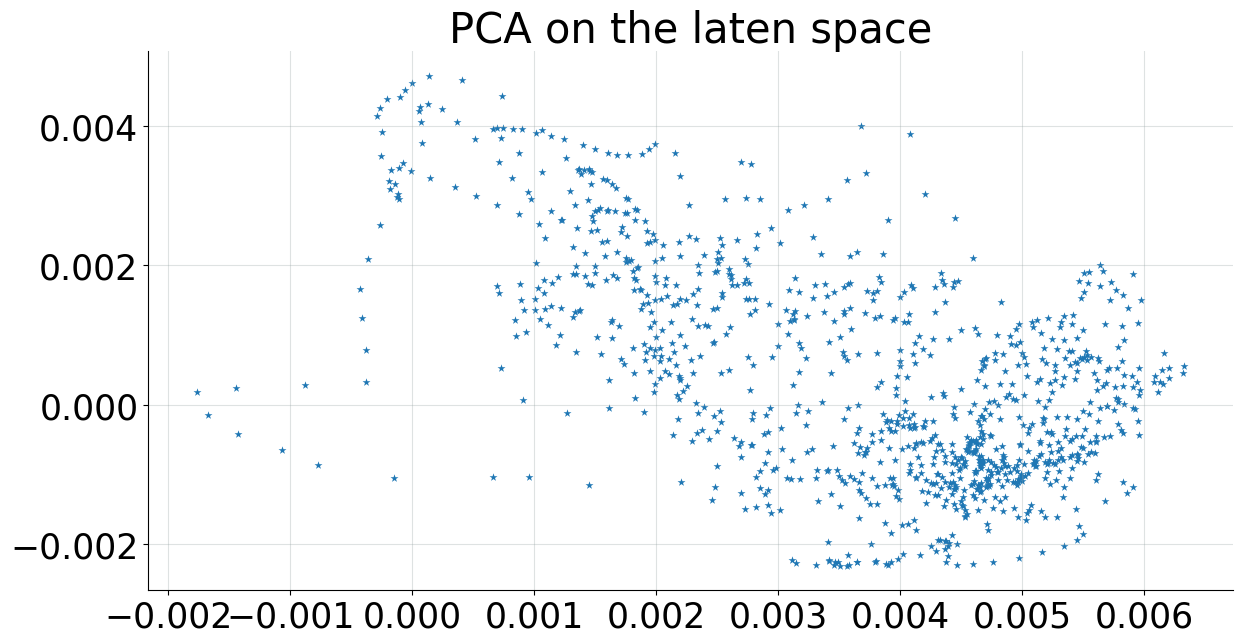

In [183]:
plot_latent(z)